# **Data Analysis of Argentina's Victory at the 2022 FIFA Men’s World Cup**

## **Data Extraction and Processing:**

**Checking which JSON files in the GitHub open data repository contain Men's World Cup data:**

In [ ]:
import requests
import json
import os
import pandas as pd
import numpy as np
import math
import gzip
from scipy.stats import gaussian_kde
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import timedelta
from tqdm import tqdm
from collections import defaultdict
from collections import Counter

In [ ]:
!pip install mplsoccer==1.2.4 --quiet
from mplsoccer import Pitch  # Importing soccer pitch module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.9 MB/s eta 0:00:00


**Selecting the 2022 edition:**

In [ ]:
MATCHES_URL = "https://raw.githubusercontent.com/a-partha/capstone-data/refs/heads/master/data/matches/43/106.json"

response = requests.get(MATCHES_URL)

if response.status_code == 200:
    matches = response.json()

    # Ensuring that the directory exists before saving
    os.makedirs("data/raw", exist_ok=True)

    # Saving the file
    with open("data/raw/fifa_2022_matches.json", "w") as f:
        json.dump(matches, f, indent=4)

    print("Successfully downloaded FIFA 2022 match data.")
else:
    print(f"Error {response.status_code}: Unable to fetch match data")


**Searching and downloading Argentina's matches (games) only:**

In [ ]:
with open("data/raw/fifa_2022_matches.json", "r") as f:
    matches = json.load(f)

# Filtering matches in which Argentina played
argentina_matches = [
    match for match in matches
    if match['home_team']['home_team_name'] == "Argentina" or match['away_team']['away_team_name'] == "Argentina"
]

# Saving
with open("data/raw/argentina_matches.json", "w") as f:
    json.dump(argentina_matches, f, indent=4)

print(f"Found {len(argentina_matches)} matches for Argentina and saved them.")


# Ensuring that the directory exists
os.makedirs("data/raw/events", exist_ok=True)

EVENT_BASE_URL = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/"

with open("data/raw/argentina_matches.json", "r") as f:
    argentina_matches = json.load(f)

# Looping through each Argentina match and downloading corresponding event data
for match in argentina_matches:
    match_id = match["match_id"]
    event_url = f"{EVENT_BASE_URL}{match_id}.json"

    response = requests.get(event_url)

    if response.status_code == 200:
        # Saving event data
        with open(f"data/raw/events/{match_id}.json", "w") as f:
            json.dump(response.json(), f, indent=4)
        print(f"Downloaded event data for match {match_id}")
    else:
        print(f"Failed to download event data for match {match_id}")

print("Event data for all matches have been downloaded")


**Type of Information Captured in the Event Data:**

In [ ]:
# All available event data files
event_files = os.listdir("data/raw/events/")

# Loading the first file for preview
sample_match_id = event_files[0].split(".")[0]  # Get a sample match ID
with open(f"data/raw/events/{sample_match_id}.json", "r") as f:
    event_data = json.load(f)

df_events = pd.DataFrame(event_data)
print(f"Event Data Columns: \n{df_events.columns}")

**Extracting Shooting, Possession, Passing, Dribbling and Defensive Metrics:**

In [ ]:
# Loading match data
with open("/content/argentina_matches.json", "r") as f:
  matches = json.load(f)

df_matches = pd.DataFrame(matches)

# Extracting basic match stats
df_matches_summary = pd.DataFrame({
  "match_id": df_matches["match_id"],
  "date": df_matches["match_date"],
  "competition": df_matches["competition"].apply(lambda x: x["competition_name"]),
  "home_team": df_matches["home_team"].apply(lambda x: x["home_team_name"]),
  "away_team": df_matches["away_team"].apply(lambda x: x["away_team_name"]),
  "home_goals": df_matches["home_score"],
  "away_goals": df_matches["away_score"]
})

# Adding count of Argentina's goals scored and conceded
df_matches_summary["goals_scored"] = df_matches_summary.apply(
  lambda x: x["home_goals"] if x["home_team"] == "Argentina" else x["away_goals"], axis=1
)
df_matches_summary["goals_conceded"] = df_matches_summary.apply(
  lambda x: x["away_goals"] if x["home_team"] == "Argentina" else x["home_goals"], axis=1
)

df_matches_summary["goal_difference"] = df_matches_summary["goals_scored"] - df_matches_summary["goals_conceded"]

# Adding opposition team
df_matches_summary["opposition"] = df_matches_summary.apply(
  lambda x: x["away_team"] if x["home_team"] == "Argentina" else x["home_team"], axis=1
)

# Sorting matches by date and arranging in mm-dd-yyyy format
df_matches_summary["date"] = pd.to_datetime(df_matches_summary["date"])
df_argentina = df_matches_summary[["date", "match_id", "opposition", "goals_scored", "goals_conceded", "goal_difference"]].sort_values(by="date").copy()  # Make a copy here
df_argentina["date"] = df_argentina["date"].dt.strftime("%m-%d-%Y")
df_argentina = df_argentina.reset_index(drop=True)  # Resetting index column

# Calculating expected goals and shot-related metrics
team_shooting_data = []
player_shooting_data = []

for match_id in df_argentina["match_id"]:
  file_path = f"/content/{match_id}.json"

  with open(file_path, "r") as f:
      event_data = json.load(f)

  df_events = pd.DataFrame(event_data)

  # Extracting shots and xG
  df_shots = df_events[df_events["type"].apply(lambda x: x["name"]) == "Shot"].copy()  # Use .copy() here
  df_shots["xG"] = df_shots["shot"].apply(lambda x: x.get("statsbomb_xg", 0) if isinstance(x, dict) else 0)

  # Shot Outcomes
  df_shots["shot_outcome"] = df_shots["shot"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None)
  shots_on_target = df_shots[df_shots["shot_outcome"].isin(["Goal", "Saved"])].shape[0]
  shots_off_target = df_shots[df_shots["shot_outcome"] == "Off T"].shape[0]
  shots_blocked = df_shots[df_shots["shot_outcome"] == "Blocked"].shape[0]
  goals_scored = df_shots[df_shots["shot_outcome"] == "Goal"].shape[0]

  # Shot Distance Calculation (Assuming Goal at (120, 40))
  df_shots["shot_distance"] = df_shots["shot"].apply(lambda x:
      np.sqrt((120 - x.get("end_location", [120, 40])[0])**2 + (40 - x.get("end_location", [120, 40])[1])**2) if isinstance(x, dict) else None)

  # Shot Type (Volley, Header, Normal, etc.)
  df_shots["shot_type"] = df_shots["shot"].apply(lambda x: x.get("technique", {}).get("name") if isinstance(x, dict) else None)

  # **Open Play vs. Set-Piece Shots
  df_shots["shot_situation"] = df_shots["shot"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None)
  open_play_shots = df_shots[df_shots["shot_situation"] == "Open Play"].shape[0]
  set_piece_shots = df_shots[df_shots["shot_situation"].isin(["Free Kick", "Corner"])].shape[0]

  # Shot Assist Type
  df_shots["assist_type"] = df_shots["shot"].apply(lambda x: x.get("key_pass_id") if isinstance(x, dict) else None)

  # Optional Metrics
  df_shots["first_time_shot"] = df_shots["shot"].apply(lambda x: x.get("first_time", False) if isinstance(x, dict) else False)
  df_shots["aerial_won"] = df_shots["shot"].apply(lambda x: x.get("aerial_won", False) if isinstance(x, dict) else False)
  df_shots["one_on_one"] = df_shots["shot"].apply(lambda x: x.get("one_on_one", False) if isinstance(x, dict) else False)

  # Shot Body Part
  df_shots["shot_body_part"] = df_shots["shot"].apply(lambda x: x.get("body_part", {}).get("name") if isinstance(x, dict) else None)

  # Aggregate Data for Argentina
  df_shots_argentina = df_shots[df_shots["team"].apply(lambda x: x["name"]) == "Argentina"].copy()
  xg_argentina = df_shots_argentina["xG"].sum().round(2)
  xg_opponent = df_shots[df_shots["team"].apply(lambda x: x["name"]) != "Argentina"]["xG"].sum().round(2)

  # Appending match stats
  team_shooting_data.append({
      "match_id": match_id,
      "xg_for": xg_argentina,
      "xg_against": xg_opponent,
      "total_shots": df_shots_argentina.shape[0],
      "shots_on_target": shots_on_target,
      "shots_off_target": shots_off_target,
      "shots_blocked": shots_blocked,
      "goals_scored": goals_scored,
      "avg_shot_distance": df_shots_argentina["shot_distance"].mean().round(2),
      "most_common_shot_type": df_shots_argentina["shot_type"].mode()[0] if not df_shots_argentina["shot_type"].mode().empty else None,
      "open_play_shots": open_play_shots,
      "set_piece_shots": set_piece_shots,
      "first_time_shots": df_shots_argentina["first_time_shot"].sum(),
      "headers_won_on_shots": df_shots_argentina["aerial_won"].sum(),
      "one_on_one_shots": df_shots_argentina["one_on_one"].sum(),
      "most_common_shot_body_part": df_shots_argentina["shot_body_part"].mode()[0] if not df_shots_argentina["shot_body_part"].mode().empty else None
  })

  # Player-Level Shooting Stats
  for player_name, df_player in df_shots_argentina.groupby(df_shots_argentina["player"].apply(lambda x: x["name"])):
      player_total_shots = len(df_player)
      player_shots_on_target = df_player[df_player["shot_outcome"].isin(["Goal", "Saved"])].shape[0]
      player_shots_off_target = df_player[df_player["shot_outcome"] == "Off T"].shape[0]
      player_shots_blocked = df_player[df_player["shot_outcome"] == "Blocked"].shape[0]
      player_goals = df_player[df_player["shot_outcome"] == "Goal"].shape[0]
      player_avg_shot_distance = df_player["shot_distance"].mean().round(2)
      player_most_common_shot_type = df_player["shot_type"].mode()[0] if not df_player["shot_type"].mode().empty else None
      player_open_play_shots = df_player[df_player["shot_situation"] == "Open Play"].shape[0]
      player_set_piece_shots = df_player[df_player["shot_situation"].isin(["Free Kick", "Corner"])].shape[0]

      player_shooting_data.append({
          "match_id": match_id,
          "player_name": player_name,
          "total_shots": player_total_shots,
          "shots_on_target": player_shots_on_target,
          "shots_off_target": player_shots_off_target,
          "shots_blocked": player_shots_blocked,
          "goals_scored": player_goals,
          "avg_shot_distance": player_avg_shot_distance,
          "most_common_shot_type": player_most_common_shot_type,
          "open_play_shots": player_open_play_shots,
          "set_piece_shots": player_set_piece_shots
      })

# Merging xG and shot data with match stats
df_shooting_team = pd.DataFrame(team_shooting_data)
df_shooting_players = pd.DataFrame(player_shooting_data)
df_argentina = df_argentina.merge(df_shooting_team, on="match_id", how="left")
df_argentina = df_argentina.drop(columns=["goals_scored_y"], errors="ignore")
df_argentina = df_argentina.rename(columns={"goals_scored_x": "goals_scored"})

# Calculating xG difference
df_argentina["xg_difference"] = df_argentina["xg_for"] - df_argentina["xg_against"]

# #Team's Cumulative Shooting Metrics
# df_shooting_team

# # Shooting Metrics per Player Who Took At Least One Shot
# df_shooting_players

# Adding Argentina's ball possession percentage:
possession_time = []

for match_id in df_argentina["match_id"]:
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

    # Filter only events with valid timestamps and duration
    df_events["duration"] = df_events["duration"].fillna(0)

    # Sum duration for each team
    team_possession_time = df_events.groupby(df_events["possession_team"].apply(lambda x: x["name"] if isinstance(x, dict) else None))["duration"].sum()

    # Extract Argentina’s possession time
    argentina_possession_time = team_possession_time.get("Argentina", 0)

    # Total match time is sum of all durations
    total_match_time = team_possession_time.sum()

    # FIFA-style possession %
    possession_percentage = (argentina_possession_time / total_match_time) * 100 if total_match_time > 0 else 0

    possession_time.append({"match_id": match_id, "possession_percentage": round(possession_percentage, 2)})

# Converting to DataFrame
df_fifa_possession = pd.DataFrame(possession_time)

# Merging with df_argentina
df_argentina = df_argentina.merge(df_fifa_possession, on="match_id", how="left")

# Extracting Passing metrics:
passing_data = []
player_passing_data = []

for match_id in df_argentina["match_id"]:
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

    # Extract pass events
    df_passes = df_events[df_events["type"].apply(lambda x: x["name"]) == "Pass"]

    # Filter only Argentina's passes
    df_passes_argentina = df_passes[df_passes["team"].apply(lambda x: x["name"]) == "Argentina"]

    #Team-Level Stats
    total_passes = len(df_passes_argentina)
    completed_passes = df_passes_argentina["pass"].apply(lambda x: x.get("outcome", {}).get("name") != "Incomplete" if isinstance(x, dict) else False).sum()
    pass_completion = round((completed_passes / total_passes) * 100, 2) if total_passes > 0 else 0
    avg_pass_length = round(df_passes_argentina["pass"].apply(lambda x: x.get("length", 0) if isinstance(x, dict) else 0).mean(), 2)
    long_passes = df_passes_argentina["pass"].apply(lambda x: x.get("switch", False) if isinstance(x, dict) else False).sum()
    key_passes = df_passes_argentina["pass"].apply(lambda x: x.get("shot_assist", False) if isinstance(x, dict) else False).sum()
    goal_assists = df_passes_argentina["pass"].apply(lambda x: x.get("goal_assist", False) if isinstance(x, dict) else False).sum()

    passing_data.append({
        "match_id": match_id,
        "total_passes": total_passes,
        "pass_completion": pass_completion,
        "avg_pass_length": avg_pass_length,
        "long_passes": long_passes,
        "key_passes": key_passes,
        "assists": goal_assists
    })

    # Player-Level Stats
    for player_name, df_player in df_passes_argentina.groupby(df_passes_argentina["player"].apply(lambda x: x["name"])):
        player_total_passes = len(df_player)
        player_completed_passes = df_player["pass"].apply(lambda x: x.get("outcome", {}).get("name") != "Incomplete" if isinstance(x, dict) else False).sum()
        player_pass_completion = round((player_completed_passes / player_total_passes) * 100, 2) if player_total_passes > 0 else 0
        player_avg_pass_length = round(df_player["pass"].apply(lambda x: x.get("length", 0) if isinstance(x, dict) else 0).mean(), 2)
        player_long_passes = df_player["pass"].apply(lambda x: x.get("switch", False) if isinstance(x, dict) else False).sum()
        player_key_passes = df_player["pass"].apply(lambda x: x.get("shot_assist", False) if isinstance(x, dict) else False).sum()
        player_goal_assists = df_player["pass"].apply(lambda x: x.get("goal_assist", False) if isinstance(x, dict) else False).sum()

        player_passing_data.append({
            "match_id": match_id,
            "player_name": player_name,
            "total_passes": player_total_passes,
            "pass_completion": player_pass_completion,
            "avg_pass_length": player_avg_pass_length,
            "long_passes": player_long_passes,
            "key_passes": player_key_passes,
            "assists": player_goal_assists
        })

# Convert to DataFrames
df_passing = pd.DataFrame(passing_data)
df_passing_players = pd.DataFrame(player_passing_data)

# Merge with Argentina's match summary
df_argentina = df_argentina.merge(df_passing, on="match_id", how="left")

# #Team's Cumulative Passing Metrics
# df_passing

# # Passing Metrics per Player
# df_passing_players

# Extracting Dribbling Metrics
dribble_data = []
player_dribble_data = []

for match_id in df_argentina["match_id"]:  # Loop over all matches
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

    # **TEAM-LEVEL DRIBBLING METRICS**
    df_dribbles = df_events[df_events["type"].apply(lambda x: x["name"]) == "Dribble"].copy()
    df_dribbles["dribble_outcome"] = df_dribbles["dribble"].apply(
        lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None
    )
    df_dribbles_argentina = df_dribbles[df_dribbles["team"].apply(lambda x: x["name"]) == "Argentina"].copy()

    dribbles_attempted = df_dribbles_argentina.shape[0]
    dribbles_completed = df_dribbles_argentina[
        df_dribbles_argentina["dribble_outcome"] == "Complete"
    ].shape[0]

    df_carries = df_events[df_events["type"].apply(lambda x: x["name"]) == "Carry"].copy()
    df_carries["carry_distance"] = df_carries["carry"].apply(
        lambda x: np.sqrt((x.get("end_location", [0, 0])[0] - x.get("location", [0, 0])[0])**2 +
                          (x.get("end_location", [0, 0])[1] - x.get("location", [0, 0])[1])**2)
        if isinstance(x, dict) else 0
    )
    df_carries_argentina = df_carries[df_carries["team"].apply(lambda x: x["name"]) == "Argentina"].copy()

    carries_total = df_carries_argentina.shape[0]
    progressive_carries = df_carries_argentina[
        df_carries_argentina["carry_distance"] >= 10
    ].shape[0]

    dribble_data.append({
        "match_id": match_id,
        "dribbles_attempted": dribbles_attempted,
        "dribbles_completed": dribbles_completed,
        "carries": carries_total,
        "progressive_carries": progressive_carries
    })

    # **PLAYER-LEVEL DRIBBLING METRICS**
    player_stats = {}

    # Process Dribbles
    for player_name, df_player in df_dribbles_argentina.groupby(
        df_dribbles_argentina["player"].apply(lambda x: x["name"])
    ):
        player_stats[player_name] = {
            "match_id": match_id,
            "player_name": player_name,
            "dribbles_attempted": len(df_player),
            "dribbles_completed": df_player[df_player["dribble_outcome"] == "Complete"].shape[0],
            "carries": 0,  # Placeholder until carries are processed
            "progressive_carries": 0
        }

    # Process Carries
    for player_name, df_player in df_carries_argentina.groupby(
        df_carries_argentina["player"].apply(lambda x: x["name"])
    ):
        if player_name in player_stats:
            player_stats[player_name]["carries"] = len(df_player)
            player_stats[player_name]["progressive_carries"] = df_player[
                df_player["carry_distance"] >= 10
            ].shape[0]
        else:
            player_stats[player_name] = {
                "match_id": match_id,
                "player_name": player_name,
                "dribbles_attempted": 0,  # Placeholder until dribbles are processed
                "dribbles_completed": 0,
                "carries": len(df_player),
                "progressive_carries": df_player[
                    df_player["carry_distance"] >= 10
                ].shape[0]
            }

    # Append all player stats for this match
    player_dribble_data.extend(player_stats.values())

df_dribble_progression = pd.DataFrame(dribble_data)  # Team-Level Dribbling Data
df_dribble_players = pd.DataFrame(player_dribble_data)  # Player-Level Dribbling Data

df_argentina = df_argentina.merge(df_dribble_progression, on="match_id", how="left")

# # Team's Cumulative Dribbling Metrics
# df_dribble_progression

# # Dribbling Metrics per Player
# df_dribble_players

# Extracting Defensive Metrics
defensive_metrics=[]
player_defensive_data=[]
player_positioning_data=[]

for match_id in df_argentina["match_id"]:  # Looping over all matches
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

    # Filtering only Argentina's defensive actions directly from df_events
    df_arg_defense = df_events[df_events["team"].apply(lambda x: x["name"]) == "Argentina"]

    # Extracting defensive stats
    total_pressures = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Pressure"].shape[0]
    total_interceptions = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Interception"].shape[0]
    total_tackles = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Tackle")
    ].shape[0]
      # Extracting tackle types
    tackles_won = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Won")
    ].shape[0]

    tackles_lost_in_play = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Lost In Play")
    ].shape[0]

    tackles_lost_out = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Lost Out")
    ].shape[0]

    tackles_success_in_play = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Success In Play")
    ].shape[0]

    tackles_success_out = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Success Out")
    ].shape[0]

    total_blocks = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Block"].shape[0]
    total_clearances = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Clearance"].shape[0]
    total_aerial_won = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Aerial Won")
    ].shape[0]
    total_aerial_lost = df_arg_defense[
      (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
      (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Aerial Lost")
    ].shape[0]
    total_ball_recoveries = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Ball Recovery"].shape[0]
    total_counterpresses = df_arg_defense[df_arg_defense["counterpress"] == True].shape[0]

    # Extracting defensive actions needed for PPDA
    total_interceptions = df_arg_defense[df_arg_defense["type"].apply(lambda x: x["name"]) == "Interception"].shape[0]
    tackles_total = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
        (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Tackle")
    ].shape[0]

    fouls_committed = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Foul Committed") &
        (df_arg_defense["foul_committed"].apply(lambda x: x.get("offensive", False) if isinstance(x, dict) else False) == False)
    ].shape[0]

    # Extract 'end_location' safely from Pass events (ID: 30)
    df_events["end_location"] = df_events["pass"].apply(
        lambda x: x.get("end_location", None) if isinstance(x, dict) else None
    )

    # Defining the pressing zone
    def is_in_pressing_zone(location):
        return isinstance(location, list) and location[0] > 40

    # Counting opponent passes that END in the pressing zone (x > 40)
    opponent_passes = df_events[
        (df_events["team"].apply(lambda x: x["name"]) != "Argentina") &  # Opponent team
        (df_events["type"].apply(lambda x: x.get("id", None) == 30)) &  # Pass events only
        (df_events["end_location"].notna()) &  # Ensure end_location is not missing
        (df_events["end_location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40))  # Pass ends in pressing zone
    ].shape[0]

    # Counting PPDA defensive actions in the pressing zone
    count_ppda_defensive_actions = df_arg_defense[
        (
            (df_arg_defense["type"].apply(lambda x: x["name"]) == "50/50") |
            ((df_arg_defense["type"].apply(lambda x: x["name"]) == "Block") &
             (df_arg_defense["counterpress"] == True)) |
            ((df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
             (df_arg_defense["counterpress"] == True) &
             (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None).isin(["Tackle", "Aerial Lost"]))) |
            (df_arg_defense["type"].apply(lambda x: x["name"]) == "Foul Committed") |
            (df_arg_defense["type"].apply(lambda x: x["name"]) == "Interception") |
            ((df_arg_defense["type"].apply(lambda x: x["name"]) == "Clearance") &
             (df_arg_defense["clearance"].apply(lambda x: x.get("aerial_won", False) if isinstance(x, dict) else False)))
        ) &
        (df_arg_defense["location"].apply(is_in_pressing_zone))  # Ensuring action is in pressing zone
    ].shape[0]

    # Counting Only Pressures in the Pressing Zone for Secondary PPDA Calculation
    pressure_actions = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x.get("id", None) == 17)) &  # Pressure event only
        (df_arg_defense["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40))  # In pressing zone
    ].shape[0]


    # Calculating PPDA (Opponent Passes divided by Defensive Actions)
    ppda = opponent_passes / count_ppda_defensive_actions if count_ppda_defensive_actions > 0 else None

    # Calculating Secondary PPDA (Using Only Pressures)
    ppda_pressures = opponent_passes / pressure_actions if pressure_actions > 0 else None

    defensive_metrics.append({
        "match_id": match_id,
        "ppda_std": ppda,
        "ppda_statsbomb": ppda_pressures,
        "pressures": total_pressures,
        "interceptions": total_interceptions,
        "tackles_total": total_tackles,
        "tackles_won": tackles_won,
        "tackles_lost_in_play": tackles_lost_in_play,
        "tackles_lost_out": tackles_lost_out,
        "tackles_success_in_play": tackles_success_in_play,
        "tackles_success_out": tackles_success_out,
        "blocks": total_blocks,
        "clearances": total_clearances,
        "aerial_duels_won": total_aerial_won,
        "aerial_duels_lost": total_aerial_lost,
        "ball_recoveries": total_ball_recoveries,
        "counterpresses": total_counterpresses
    })

    # PLAYER-LEVEL DEFENSIVE METRICS
    player_stats = {}

    # Handling missing player values
    df_arg_defense = df_arg_defense.dropna(subset=["player"])  # Drop rows where player is NaN

    for player_name, df_player in df_arg_defense.dropna(subset=["player"]).groupby(df_arg_defense["player"].apply(lambda x: x.get("name", "Unknown") if isinstance(x, dict) else "Unknown")):
      player_stats[player_name] = {
            "match_id": match_id,
            "player_name": player_name,
            "pressures": df_player[df_player["type"].apply(lambda x: x["name"]) == "Pressure"].shape[0],
            "interceptions": df_player[df_player["type"].apply(lambda x: x["name"]) == "Interception"].shape[0],
            "tackles_total": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Tackle")
            ].shape[0],
            "tackles_won": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Won")
            ].shape[0],
            "tackles_lost_in_play": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Lost In Play")
            ].shape[0],
            "tackles_lost_out": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Lost Out")
            ].shape[0],
            "tackles_success_in_play": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Success In Play")
            ].shape[0],
            "tackles_success_out": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("outcome", {}).get("name") if isinstance(x, dict) else None) == "Success Out")
            ].shape[0],
            "blocks": df_player[df_player["type"].apply(lambda x: x["name"]) == "Block"].shape[0],
            "clearances": df_player[df_player["type"].apply(lambda x: x["name"]) == "Clearance"].shape[0],
            "aerial_duels_won": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Aerial Won")
            ].shape[0],
            "aerial_duels_lost": df_player[
                (df_player["type"].apply(lambda x: x["name"]) == "Duel") &
                (df_player["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Aerial Lost")
            ].shape[0],
            "ball_recoveries": df_player[df_player["type"].apply(lambda x: x["name"]) == "Ball Recovery"].shape[0],
            "counterpresses": df_player[df_player["counterpress"] == True].shape[0]
        }

      df_player_copy = df_player.dropna(subset=["location"]).copy()

      # Extracting player locations for heatmaps
      if not df_player_copy.empty:
          df_player_copy["x"], df_player_copy["y"] = zip(*df_player_copy["location"])

          # Storing player positioning data
          player_positioning_data.append({
              "match_id": match_id,
              "player_name": player_name,
              "x_positions": df_player_copy["x"].tolist(),
              "y_positions": df_player_copy["y"].tolist()
          })

      # Append all player stats for this match
      player_defensive_data.extend(player_stats.values())

# Convert extracted defensive metrics into a DataFrame
df_defensive = pd.DataFrame(defensive_metrics)
df_defensive_players = pd.DataFrame(player_defensive_data)

# Merge defensive stats into df_argentina without overwriting existing columns
df_argentina = df_argentina.merge(df_defensive, on="match_id", how="left")

# Convert player positioning data into a DataFrame
df_player_positions = pd.DataFrame(player_positioning_data)

# Merge positioning data into df_defensive_players
df_defensive_players = df_defensive_players.merge(df_player_positions, on=["match_id", "player_name"], how="left")

# # Team's Cumulative Defensive Metrics
# df_defensive

# # Defensive Metrics per Player (with at least One Defensive Contribution)
# df_defensive_players


**Types of Defensive Metrics Extracted:**

* **Pressures** → Pressing intensity.
* **Interceptions** → Cutting passing lanes.
* **Tackles Total** → Regaining ball possession via tackling.
* **Tackles Won** → The defender successfully wins possession.
* **Tackles Lost in Play** → The ball stays in play, but the opponent or another player gets possession.
* **Tackles Lost Out** → The tackle knocks the ball out of bounds, giving possession to the opponent.
* **Tackles Success in Play** → The ball is won cleanly, and the defending team keeps it.
* **Tackles Success Out** → The ball is won but goes out of play in favor of the defender’s team.
* **Blocks** → Blocking shots/passes.
* **Clearances** → Clearing the ball during dangerous situations.
* **Aerial Duels (Won/Lost)** → Effectiveness in the air.
* **Ball Recoveries** → Regaining ball possession from loose balls.
* **Counterpressing Actions** → Applying pressure within 5 seconds of losing possession.

In [ ]:
df_argentina.columns

Index(['date', 'match_id', 'opposition', 'goals_scored', 'goals_conceded',
       'goal_difference', 'xg_for', 'xg_against', 'total_shots',
       'shots_on_target', 'shots_off_target', 'shots_blocked',
       'avg_shot_distance', 'most_common_shot_type', 'open_play_shots',
       'set_piece_shots', 'first_time_shots', 'headers_won_on_shots',
       'one_on_one_shots', 'most_common_shot_body_part', 'xg_difference',
       'possession_percentage', 'total_passes', 'pass_completion',
       'avg_pass_length', 'long_passes', 'key_passes', 'assists',
       'dribbles_attempted', 'dribbles_completed', 'carries',
       'progressive_carries', 'ppda_std', 'ppda_statsbomb', 'pressures',
       'interceptions', 'tackles_total', 'tackles_won', 'tackles_lost_in_play',
       'tackles_lost_out', 'tackles_success_in_play', 'tackles_success_out',
       'blocks', 'clearances', 'aerial_duels_won', 'aerial_duels_lost',
       'ball_recoveries', 'counterpresses'],
      dtype='object')

In [ ]:
df_defensive

,match_id,ppda_std,ppda_statsbomb,pressures,interceptions,tackles_total,tackles_won,tackles_lost_in_play,tackles_lost_out,tackles_success_in_play,tackles_success_out,blocks,clearances,aerial_duels_won,aerial_duels_lost,ball_recoveries,counterpresses
0,3857300,10.083333,3.666667,107,11,13,4,6,2,1,0,19,18,0,10,44,42
1,3857289,12.000000,4.628571,109,5,18,2,4,3,8,1,17,20,0,20,34,49
2,3857264,10.130435,3.530303,88,7,15,2,2,3,8,0,12,7,0,12,53,44
3,3869151,10.384615,2.783505,127,16,16,4,4,0,6,2,13,25,0,17,47,55
4,3869321,20.000000,3.969466,190,10,22,3,5,6,8,0,16,27,0,21,48,53
5,3869519,16.300000,3.880952,192,8,24,4,9,2,9,0,23,18,0,10,40,65
6,3869685,8.600000,4.637255,167,13,26,8,5,6,7,0,26,26,0,24,59,89


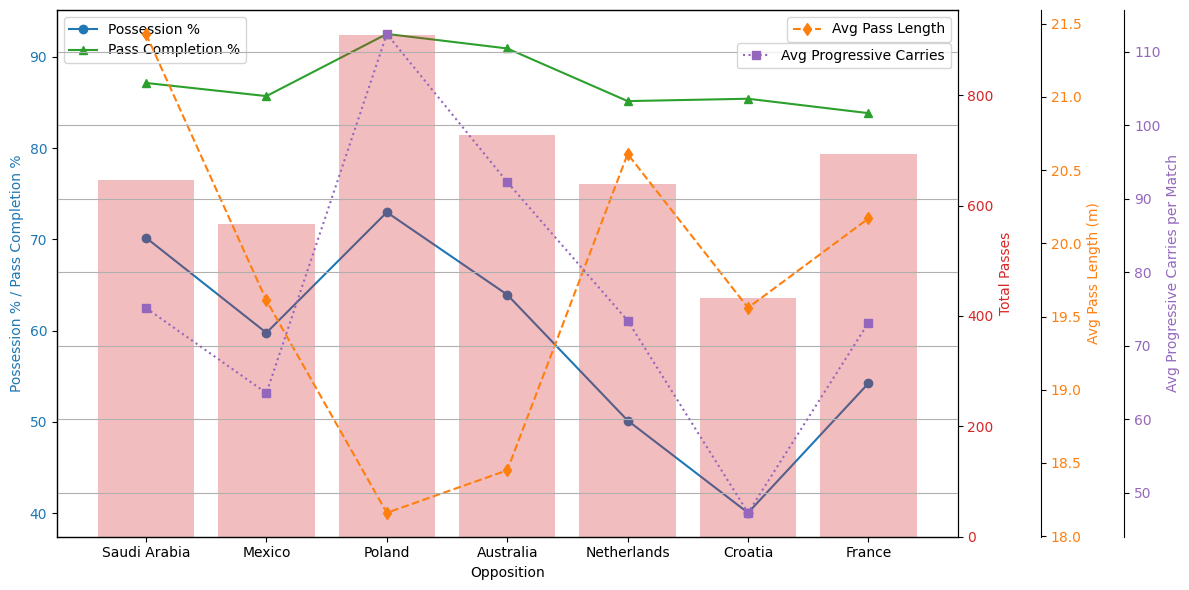

In [ ]:
# Calculate average progressive carries per match
df_argentina["avg_progressive_carries"] = df_argentina["progressive_carries"] / df_argentina.shape[0]

# Figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis (Possession %, Pass Completion %)
ax1.set_xlabel("Opposition")
ax1.set_ylabel("Possession % / Pass Completion %", color="tab:blue")
ax1.plot(df_argentina["opposition"], df_argentina["possession_percentage"], label="Possession %", marker="o", color="tab:blue")
ax1.plot(df_argentina["opposition"], df_argentina["pass_completion"], label="Pass Completion %", marker="^", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")

# Secondary y-axis (Total Passes - Bar Chart for clarity)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Passes", color="tab:red")
ax2.bar(df_argentina["opposition"], df_argentina["total_passes"], color="tab:red", alpha=0.3)
ax2.tick_params(axis="y", labelcolor="tab:red")
# ax2.legend(loc="upper right")

# Third y-axis (Avg Pass Length)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third axis for clarity
ax3.set_ylabel("Avg Pass Length (m)", color="tab:orange")
ax3.plot(df_argentina["opposition"], df_argentina["avg_pass_length"], label="Avg Pass Length", marker="d", linestyle="dashed", color="tab:orange")
ax3.tick_params(axis="y", labelcolor="tab:orange")
ax3.legend(loc="upper right")  # Move legend slightly lower

# Fourth y-axis (Average Progressive Carries - Scale Adjusted)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  # Offset further for visibility
ax4.set_ylabel("Avg Progressive Carries per Match", color="tab:purple")
ax4.plot(df_argentina["opposition"], df_argentina["avg_progressive_carries"], label="Avg Progressive Carries", marker="s", linestyle="dotted", color="tab:purple")
ax4.tick_params(axis="y", labelcolor="tab:purple")
ax4.legend(loc="upper right", bbox_to_anchor=(1, 0.95))  # Fourth y-axis legend at the lowest position

# Title and grid
# plt.title("Argentina Per Match Team Stats")
fig.tight_layout()
plt.grid(True)

# Show plot
plt.show()


* **Carry** → any movement with the ball at a player’s feet, regardless of distance. It starts when a player gains control of the ball and ends when they release it (pass, shot, loss of possession, or stoppage).

* **Progressive Carry** →  when the ball was moved at least 10 meters towards the opponent’s goal.

The above plot reflects Argentina's matches at the tournment in terms of on-the-ball play. For example, they dominated play against Poland and Australia (who were quite passive) but let Croatia have the ball in the semifinals to avoid going toe-to-toe with the Croatian midfield which was very good on a technical level. More on this soon...

# **Argentina Without the Ball**

## **Regression for PPDA:**

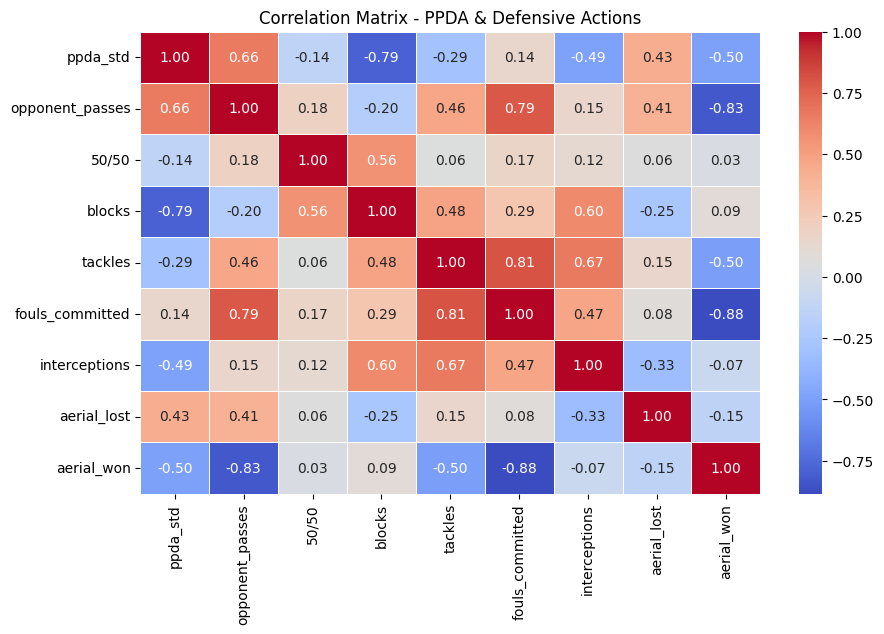

In [ ]:
# Extracting PPDA Defensive Actions from df_arg_defense
ppda_defensive_actions = []

for match_id in df_argentina["match_id"]:
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)
    df_arg_defense = df_events[df_events["team"].apply(lambda x: x["name"]) == "Argentina"]

    # Defining the pressing zone (x > 40)
    def is_in_pressing_zone(location):
        return isinstance(location, list) and location[0] > 40

    # Extracting 'end_location' safely from Pass events (ID: 30)
    df_events["end_location"] = df_events["pass"].apply(
        lambda x: x.get("end_location", None) if isinstance(x, dict) else None
    )

    # Counting opponent passes that END in the pressing zone (x > 40)
    opponent_passes = df_events[
        (df_events["team"].apply(lambda x: x["name"]) != "Argentina") &  # Opponent team
        (df_events["type"].apply(lambda x: x.get("id", None) == 30)) &  # Pass events only
        (df_events["end_location"].notna()) &  # Ensure end_location is not missing
        (df_events["end_location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40))  # Pass ends in pressing zone
    ].shape[0]

    # Extracting counts of each PPDA Defensive Action
    fifty_fifty = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "50/50") &
        (df_arg_defense["location"].apply(is_in_pressing_zone))
    ].shape[0]

    blocks = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Block") &
        (df_arg_defense["counterpress"] == True) &
        (df_arg_defense["location"].apply(is_in_pressing_zone))
    ].shape[0]


    # Extracting only "Tackle" duels
    duels_tackles = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
        (df_arg_defense["counterpress"] == True) &  # Must be during counterpressing
        (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Tackle") &
        (df_arg_defense["location"].apply(is_in_pressing_zone))  # Must be in pressing zone
    ].shape[0]

    # Extracting only "Aerial Lost" duels
    duels_aerial_lost = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Duel") &
        (df_arg_defense["counterpress"] == True) &  # Must be during counterpressing
        (df_arg_defense["duel"].apply(lambda x: x.get("type", {}).get("name") if isinstance(x, dict) else None) == "Aerial Lost") &
        (df_arg_defense["location"].apply(is_in_pressing_zone))  # Must be in pressing zone
    ].shape[0]


    fouls_committed = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Foul Committed") &
        (df_arg_defense["location"].apply(is_in_pressing_zone))
    ].shape[0]

    interceptions = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Interception") &
        (df_arg_defense["location"].apply(is_in_pressing_zone))
    ].shape[0]

    clearance_aerial_won = df_arg_defense[
        (df_arg_defense["type"].apply(lambda x: x["name"]) == "Clearance") &
        (df_arg_defense["clearance"].apply(lambda x: x.get("aerial_won", False) if isinstance(x, dict) else False)) &
        (df_arg_defense["location"].apply(is_in_pressing_zone))
    ].shape[0]

    # Storing results for this match
    ppda_defensive_actions.append({
        "ppda_std": df_defensive[df_defensive["match_id"] == match_id]["ppda_std"].values[0],  # Standard PPDA
        "opponent_passes": opponent_passes,
        "50/50": fifty_fifty,
        "blocks": blocks,
        "tackles": duels_tackles,
        "fouls_committed": fouls_committed,
        "interceptions": interceptions,
        "aerial_lost": duels_aerial_lost,
        "aerial_won": clearance_aerial_won
    })

# Convert to DataFrame
df_ppda = pd.DataFrame(ppda_defensive_actions)

# Compute correlation matrix
corr_matrix = df_ppda.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - PPDA & Defensive Actions")
plt.show()


In [ ]:
df_ppda

,ppda_std,opponent_passes,50/50,blocks,tackles,fouls_committed,interceptions,aerial_lost,aerial_won
0,10.083333,242,5,3,2,6,5,0,3
1,12.000000,324,3,2,6,9,2,3,2
2,10.130435,233,0,2,5,11,4,0,1
3,10.384615,270,0,1,6,7,8,1,3
4,20.000000,520,2,0,4,14,4,2,0
5,16.300000,489,2,0,7,16,4,1,0
6,8.600000,473,4,5,12,22,11,1,0


**Scatter plots with a regression line for ppda_std vs different defensive actions:**

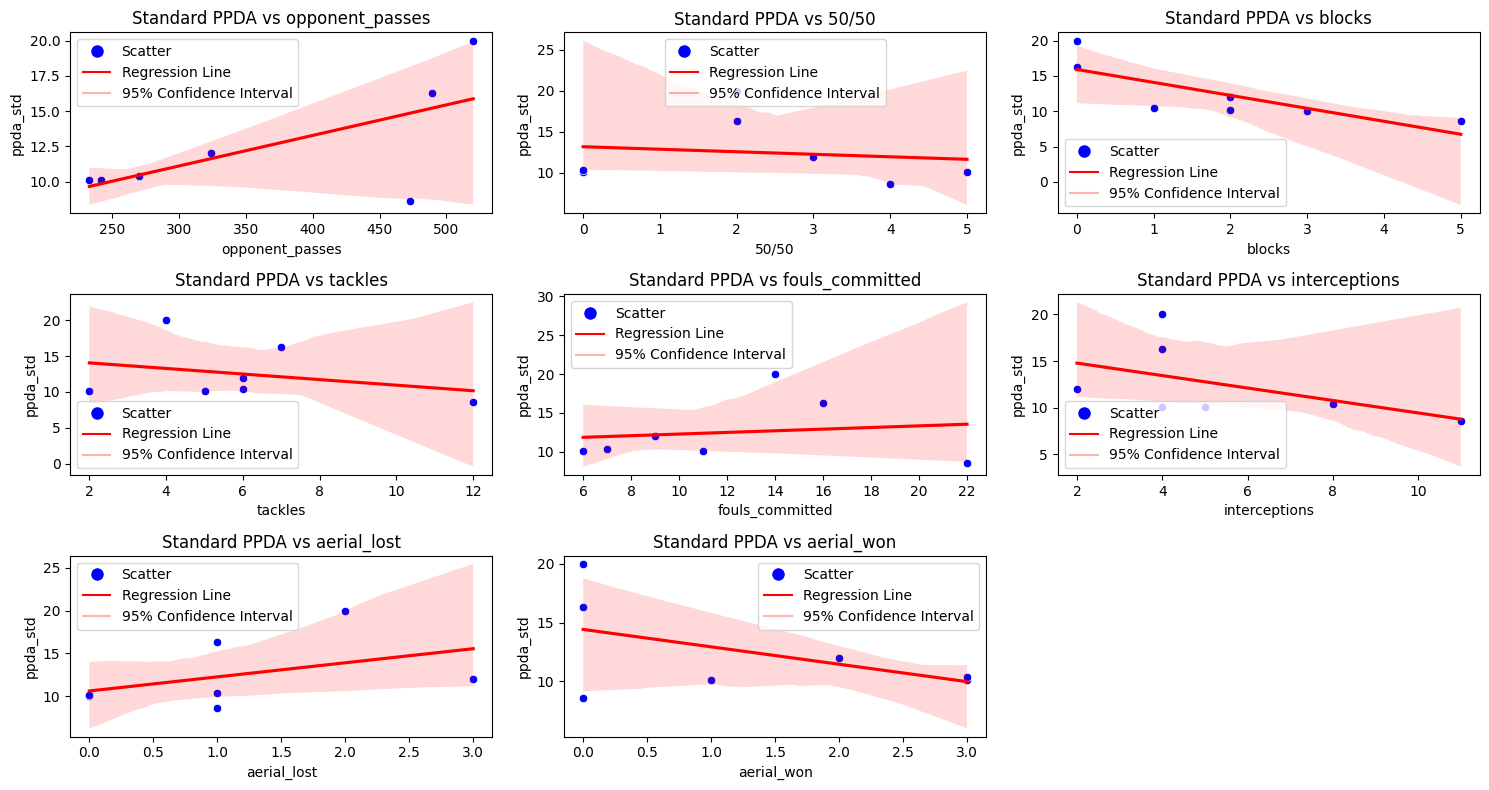

In [ ]:
# Define grid size based on the number of variables
num_vars = len(df_ppda.columns[1:])
rows = (num_vars // 3) + (num_vars % 3 > 0)  # Ensure sufficient rows
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(15, 8))

# Flatten axes to avoid indexing issues
axs = axs.flatten()

# Variables for x-axis
variables = df_ppda.columns[1:]

for i, variable in enumerate(variables):
    ax = axs[i]

    # Scatter plot
    sns.scatterplot(data=df_ppda, x=variable, y='ppda_std', ax=ax, color='blue')

    # Regression line
    sns.regplot(data=df_ppda, x=variable, y='ppda_std', ax=ax, scatter=False, color='red', label='Regression Line')

    ax.set_title(f'Standard PPDA vs {variable}')

    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Scatter'),
                     plt.Line2D([0], [0], linestyle='-', color='red', label='Regression Line'),
                     plt.Line2D([0], [0], linestyle='-', color='red', label='95% Confidence Interval', alpha=0.3)]

    ax.legend(handles=custom_legend)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### **Custom Grouping of Independent Variables:**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reload the dataset
df = pd.read_csv("standard_ppda.csv")

# Creating a DataFrame for your custom groupings
df_custom_groupings = pd.DataFrame()
df_custom_groupings["Pressing Actions"] = df["tackles"] + df["fouls_committed"] + df["50/50"]
df_custom_groupings["Structured Defense"] = df["blocks"] + df["interceptions"]
df_custom_groupings["Aerial Presence"] = df["aerial_won"] + df["aerial_lost"]
df_custom_groupings["Opponent Passes"] = df["opponent_passes"]  # Kept as a standalone factor
df_custom_groupings["ppda_std"] = df["ppda_std"]  # Adding PPDA as the target variable

# Calculating VIF to check multicollinearity in custom groupings
X_vif_custom = df_custom_groupings.drop(columns=["ppda_std"])
vif_data_custom = pd.DataFrame()
vif_data_custom["Feature"] = X_vif_custom.columns
vif_data_custom["VIF"] = [variance_inflation_factor(X_vif_custom.values, i) for i in range(X_vif_custom.shape[1])]

# Display results
vif_data_custom

,Feature,VIF
0,Pressing Actions,46.993545
1,Structured Defense,10.886578
2,Aerial Presence,3.065731
3,Opponent Passes,28.899513


In [ ]:
# Centering (Mean-adjusting) the variables to reduce multicollinearity
df_custom_groupings_centered = df_custom_groupings.copy()
for col in df_custom_groupings.columns:
    if col != "ppda_std":  # Excluding target variable
        df_custom_groupings_centered[col] = df_custom_groupings[col] - df_custom_groupings[col].mean()

# Recalculating VIF after centering
X_vif_custom_centered = df_custom_groupings_centered.drop(columns=["ppda_std"])
vif_data_custom_centered = pd.DataFrame()
vif_data_custom_centered["Feature"] = X_vif_custom_centered.columns
vif_data_custom_centered["VIF"] = [variance_inflation_factor(X_vif_custom_centered.values, i) for i in range(X_vif_custom_centered.shape[1])]

vif_data_custom_centered

,Feature,VIF
0,Pressing Actions,6.522363
1,Structured Defense,2.952712
2,Aerial Presence,1.467551
3,Opponent Passes,3.841581


We would have to remove Pressing Actions from consideration. However, since it contains important defensive actions like tackles, fouls committed and 50/50s, we have to choose another way to remove multicollinearity.

### **Hierarchical Clustering Based Grouping:**

Hierarchical clustering is a way to group similar things (like stats/features) based on how close they are to each other across data points.

It works by:
* Treating every feature as its own group.
* Gradually merging the closest ones (based on Euclidean distance).
* Using Ward’s method to keep those merges as balanced as possible.
* Drawing a dendrogram to visualize which features are similar.

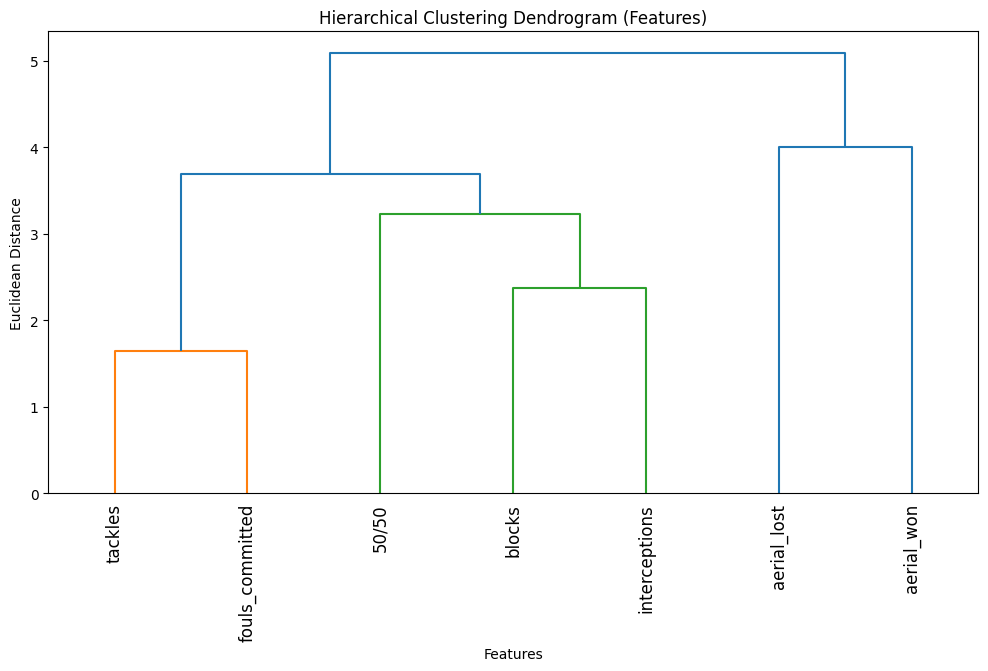

{np.int32(1): ['50/50', 'blocks', 'tackles', 'fouls_committed', 'interceptions'], np.int32(2): ['aerial_lost'], np.int32(3): ['aerial_won']}


In [ ]:
file_path = "standard_ppda.csv"
df = pd.read_csv(file_path)

df = df.drop(columns=['ppda_std','opponent_passes'])

# Standardizing ALL features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Transpose data to cluster features instead of rows
scaled_data_transposed = scaled_data.T

# Perform hierarchical clustering
linkage_matrix = sch.linkage(scaled_data_transposed, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, labels=df.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Features)")
plt.xlabel("Features")
plt.ylabel("Euclidean Distance")
plt.show()

# Determine clusters
from scipy.cluster.hierarchy import fcluster

# Assuming we expect around 3 clusters (adjustable)
num_clusters = 3
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Create a dictionary to group features by clusters
clustered_features = {}
for feature, cluster in zip(df.columns, clusters):  # Now using df.columns directly
    if cluster not in clustered_features:
        clustered_features[cluster] = []
    clustered_features[cluster].append(feature)

# Display clusters
print(clustered_features)

In [ ]:
df = pd.read_csv("standard_ppda.csv")

# Creating a DataFrame for your custom groupings
df_custom_groupings = pd.DataFrame()
df_custom_groupings["Cluster 1"] = df["tackles"] + df["blocks"] + df["fouls_committed"] + df["interceptions"]+df["50/50"]
df_custom_groupings["Cluster 2"] = df["aerial_won"]
df_custom_groupings["Cluster 3"] = df["aerial_lost"]
df_custom_groupings["Opponent Passes"] = df["opponent_passes"]  # Kept as a standalone factor
df_custom_groupings["ppda_std"] = df["ppda_std"]  # Adding PPDA as the target variable

# Calculating VIF to check multicollinearity in custom groupings
X_vif_custom = df_custom_groupings.drop(columns=["ppda_std"])
vif_data_custom = pd.DataFrame()
vif_data_custom["Feature"] = X_vif_custom.columns
vif_data_custom["VIF"] = [variance_inflation_factor(X_vif_custom.values, i) for i in range(X_vif_custom.shape[1])]

vif_data_custom

,Feature,VIF
0,Cluster 1,11.034725
1,Cluster 2,1.420275
2,Cluster 3,3.260102
3,Opponent Passes,15.394694


In [ ]:
# Centering (Mean-adjusting) the variables to reduce multicollinearity
df_custom_groupings_centered = df_custom_groupings.copy()
for col in df_custom_groupings.columns:
    if col != "ppda_std":  # Excluding target variable
        df_custom_groupings_centered[col] = df_custom_groupings[col] - df_custom_groupings[col].mean()

# Recalculating VIF after centering
X_vif_custom_centered = df_custom_groupings_centered.drop(columns=["ppda_std"])
vif_data_custom_centered = pd.DataFrame()
vif_data_custom_centered["Feature"] = X_vif_custom_centered.columns
vif_data_custom_centered["VIF"] = [variance_inflation_factor(X_vif_custom_centered.values, i) for i in range(X_vif_custom_centered.shape[1])]

vif_data_custom_centered

,Feature,VIF
0,Cluster 1,1.591604
1,Cluster 2,3.843605
2,Cluster 3,1.514744
3,Opponent Passes,4.825122


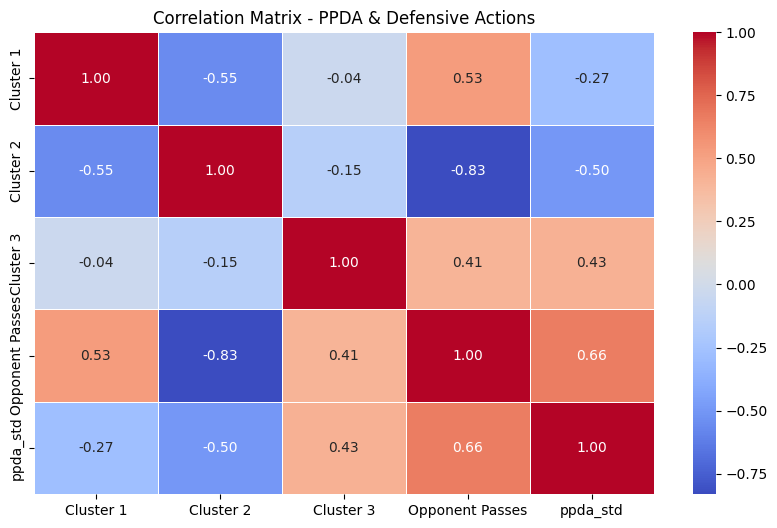

In [ ]:
# Compute correlation matrix
corr_matrix = df_custom_groupings_centered.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - PPDA & Defensive Actions")
plt.show()

In [ ]:
x = df_custom_groupings_centered[df_custom_groupings_centered.columns[0:4]]
xs = x.drop(columns=["Cluster 2","Cluster 3"])
y = df_custom_groupings_centered["ppda_std"]

xs = sm.add_constant(xs) # adding a constant

model = sm.OLS(y, xs).fit()
predictions = model.predict(xs)

model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ppda_std   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     110.6
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           0.000315
Time:                        20:33:16   Log-Likelihood:                -5.2038
No. Observations:                   7   AIC:                             16.41
Df Residuals:                       4   BIC:                             16.25
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.4998      0.254     49.126      0.000      11.793      13.206
Cluster 1          -0.3036      0.027    -11.114      0.000      -0.379      -0.228
Opponent Passes     0.0371      0.003     14.293      0.000       0.030       0.044
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.528
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.486
Skew:                           0.168   Prob(JB):                        0.784
Kurtosis:                       1.753   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Cluster 1 (**tackles, blocks, fouls committed, interceptions, 50/50**) + Opponent Passes **explain 98.2% of ppda**.

The coefficient for Cluster 1 means that if the number of opponent passes is held constant, a **one-unit increase in pressing actions leads to a 0.3 decrease in PPDA on average**.

### **Colin Trainor's Definition based Grouping of Independent Variables:**

Colin Trainor's defensive actions - *tackles, fouls committed and interceptions*.

In [ ]:
df = pd.read_csv("standard_ppda.csv")

# Creating a DataFrame for your custom groupings
df_custom_groupings = pd.DataFrame()
df_custom_groupings["Defined Actions"] = df["tackles"] + df["fouls_committed"] + df["interceptions"]
df_custom_groupings["Remaining Actions"] = df["aerial_won"]+df["aerial_lost"] + df["blocks"] + df["50/50"]
df_custom_groupings["Opponent Passes"] = df["opponent_passes"]  # Kept as a standalone factor
df_custom_groupings["ppda_std"] = df["ppda_std"]  # Adding PPDA as the target variable

# Calculating VIF to check multicollinearity in custom groupings
X_vif_custom = df_custom_groupings.drop(columns=["ppda_std"])
vif_data_custom = pd.DataFrame()
vif_data_custom["Feature"] = X_vif_custom.columns
vif_data_custom["VIF"] = [variance_inflation_factor(X_vif_custom.values, i) for i in range(X_vif_custom.shape[1])]

vif_data_custom

,Feature,VIF
0,Defined Actions,11.810540
1,Remaining Actions,3.399679
2,Opponent Passes,11.035253


In [ ]:
# Centering (Mean-adjusting) the variables to reduce multicollinearity
df_custom_groupings_centered = df_custom_groupings.copy()
for col in df_custom_groupings.columns:
    if col != "ppda_std":  # Excluding target variable
        df_custom_groupings_centered[col] = df_custom_groupings[col] - df_custom_groupings[col].mean()

# Recalculating VIF after centering
X_vif_custom_centered = df_custom_groupings_centered.drop(columns=["ppda_std"])
vif_data_custom_centered = pd.DataFrame()
vif_data_custom_centered["Feature"] = X_vif_custom_centered.columns
vif_data_custom_centered["VIF"] = [variance_inflation_factor(X_vif_custom_centered.values, i) for i in range(X_vif_custom_centered.shape[1])]

# Display results
vif_data_custom_centered

,Feature,VIF
0,Defined Actions,1.686508
1,Remaining Actions,1.098436
2,Opponent Passes,1.749592


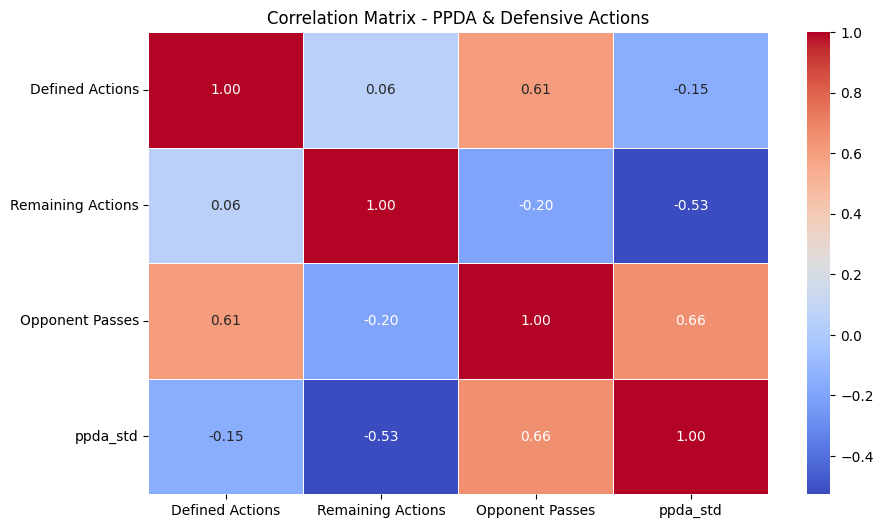

In [ ]:
# Compute correlation matrix
corr_matrix = df_custom_groupings_centered.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - PPDA & Defensive Actions")
plt.show()

In [ ]:
x = df_custom_groupings_centered[df_custom_groupings_centered.columns[0:3]]
xs = x.drop(columns=["Remaining Actions"])
y = df_custom_groupings_centered['ppda_std']

xs = sm.add_constant(xs) # adding a constant

model = sm.OLS(y, xs).fit()
predictions = model.predict(xs)

model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ppda_std   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     26.39
Date:                Tue, 18 Mar 2025   Prob (F-statistic):            0.00496
Time:                        22:20:14   Log-Likelihood:                -10.027
No. Observations:                   7   AIC:                             26.05
Df Residuals:                       4   BIC:                             25.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.4998      0.507     24.663      0.000      11.093      13.907
Defined Actions    -0.3533      0.067     -5.305      0.006      -0.538      -0.168
Opponent Passes     0.0396      0.006      7.171      0.002       0.024       0.055
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.327
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.555
Skew:                           0.060   Prob(JB):                        0.758
Kurtosis:                       1.626   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Defined Actions (**tackles, fouls committed, interceptions**) + Opponent Passes **explain 93% of PPDA**.

## **Heatmaps for Pressure Applied by Argentina:**

This shows places where Argentina applied pressure in an attempt to win the ball off the opponent. The area of the pitch considered is the opponent half plus the immediate 10% of Argentina's own half.   

Argentina attacked LEFT to RIGHT ✅


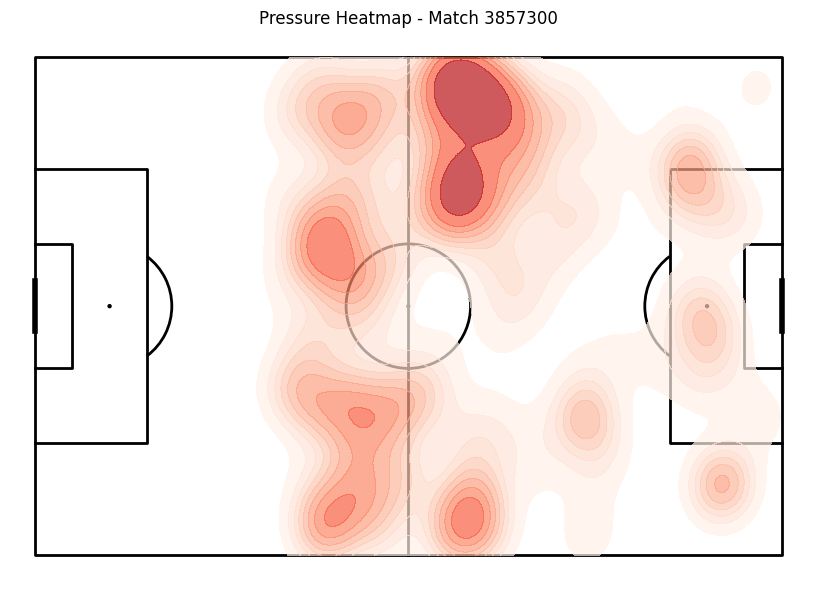

Argentina attacked LEFT to RIGHT ✅


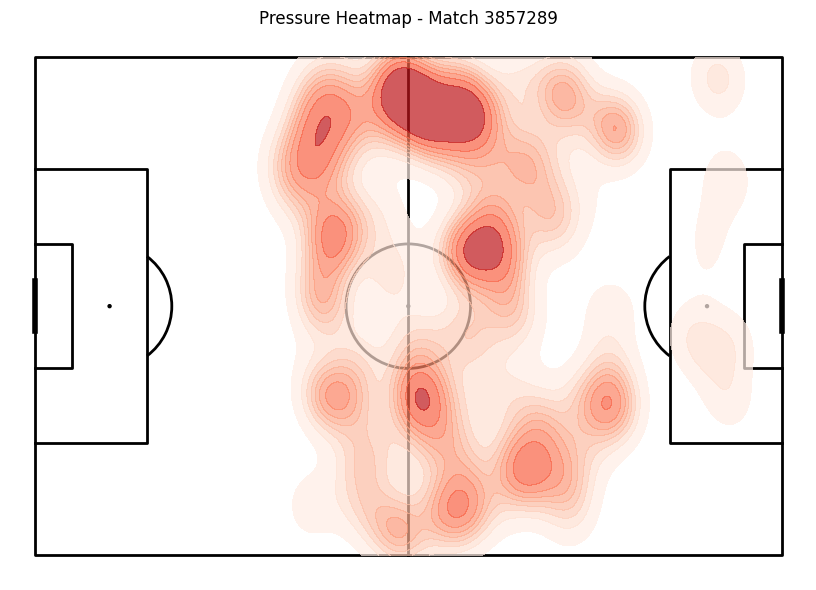

Argentina attacked LEFT to RIGHT ✅


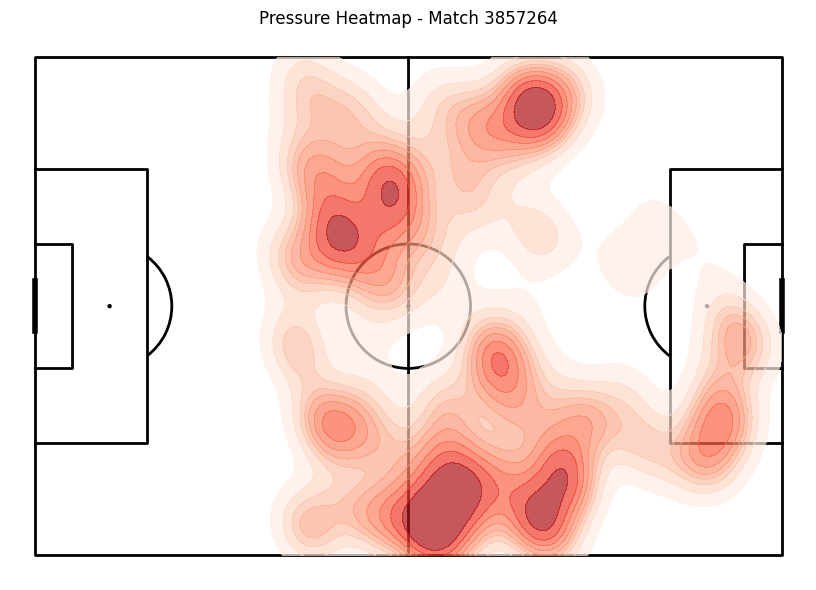

Argentina attacked LEFT to RIGHT ✅


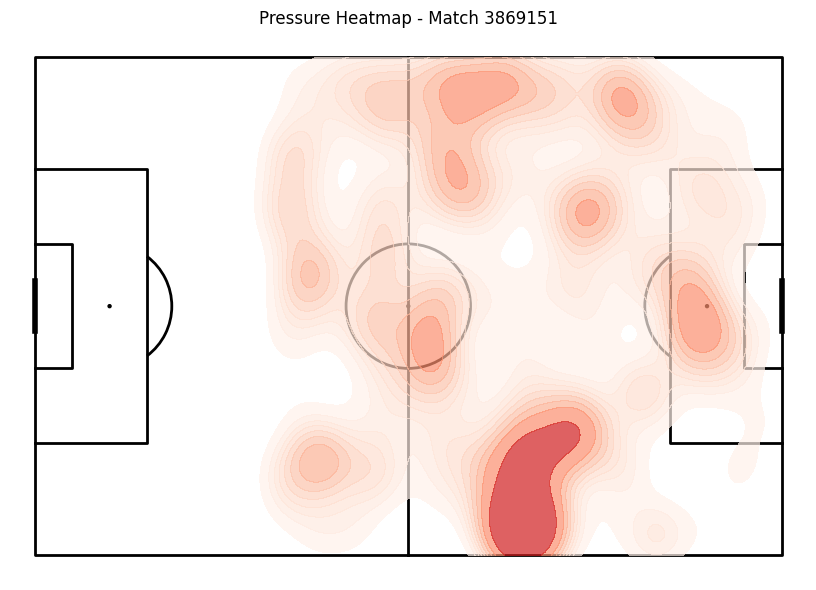

Argentina attacked LEFT to RIGHT ✅


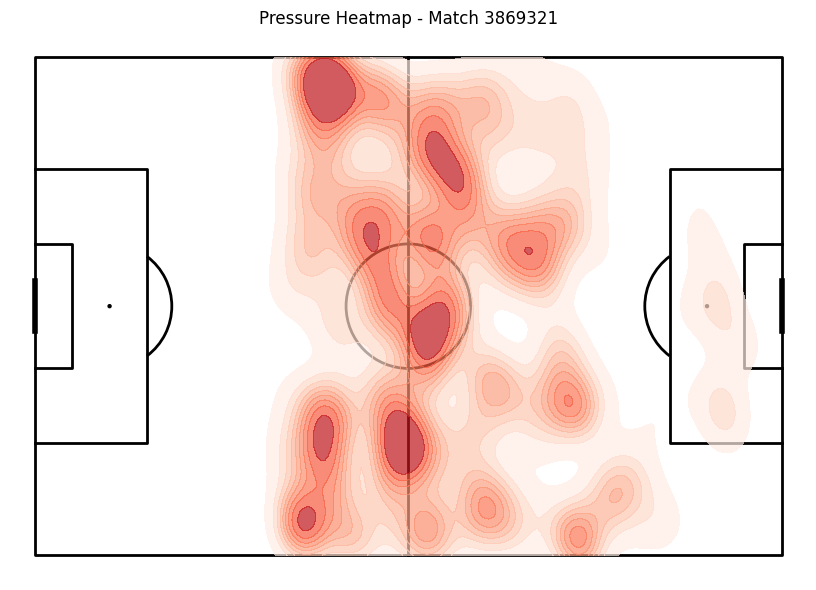

Argentina attacked LEFT to RIGHT ✅


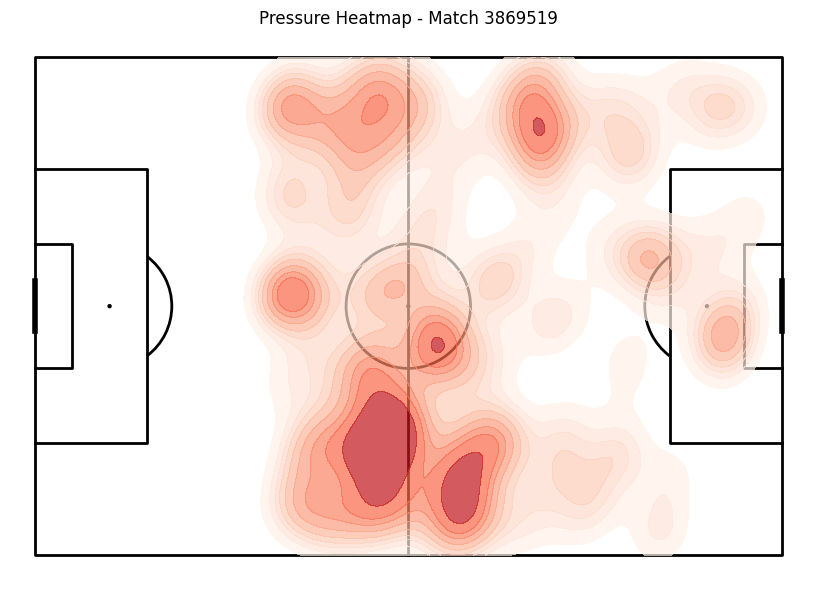

Argentina attacked LEFT to RIGHT ✅


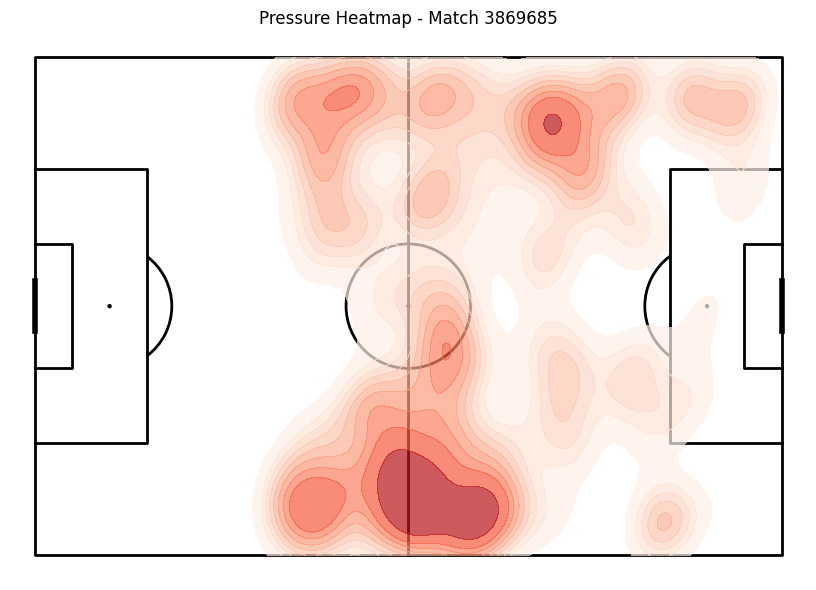

In [ ]:
df_argentina = pd.read_csv("argentina_stats.csv")

# Looping through matches to create pressure heatmaps
for match_id in df_argentina["match_id"]:
    file_path = f"/content/{match_id}.json"

    # Loading match event data
    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

     # Filtering for pressure events in the pressing zone (x > 40)
    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x["name"]) == "Pressure") &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40))
    ].copy()


    # Extracting x, y locations
    df_pressure["x"] = df_pressure["location"].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    df_pressure["y"] = df_pressure["location"].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    # Determine if Argentina attacked right to left in the first half
    first_event = df_events.iloc[0]  # Get first event of match
    first_x = first_event["location"][0] if isinstance(first_event["location"], list) else None

    # If Argentina started defending in the right goal, flip all x-coordinates
    if first_x and first_x > 60:
      df_pressure["x"] = 120 - df_pressure["x"]  # Flipping only if necessary

    # Filtering shots by Argentina
    df_shots = df_events[df_events["type"].apply(lambda x: x["name"]) == "Shot"]

    # Extracting x-coordinates of Argentina's shots
    df_shots_arg = df_shots[df_shots["team"].apply(lambda x: x["name"]) == "Argentina"]
    avg_x_shot = df_shots_arg["location"].apply(lambda loc: loc[0] if isinstance(loc, list) else None).mean()

    # Check if Argentina attacked left to right
    if avg_x_shot > 60:
        print("Argentina attacked LEFT to RIGHT ✅")
    else:
        print("Argentina attacked RIGHT to LEFT ❌ (Need to flip x-coordinates)")

    # Creating pitch with mplsoccer
    pitch = Pitch(pitch_type="statsbomb", line_color="black")
    fig, ax = pitch.draw(figsize=(10, 6))

    # Plotting KDE heatmap with clipping
    sns.kdeplot(
        x=df_pressure["x"],
        y=df_pressure["y"],
        fill=True,
        cmap="Reds",
        bw_adjust=0.4,  # Reduced for less overspreading
        alpha=0.7,
        clip=((0, 120), (0, 80)),  # Clipping KDE to stay within pitch
        ax=ax,
        weights=df_pressure["duration"]
    )

    # Formatting plot
    plt.title(f"Pressure Heatmap - Match {match_id}")

    # Displaying heatmap
    plt.show()


In [ ]:
df_argentina = pd.read_csv("argentina_stats.csv")

# Looping through matches to create pressure heatmaps
for match_id in df_argentina["match_id"]:
    file_path = f"/content/{match_id}.json"

    # Loading match event data
    with open(file_path, "r") as f:
        event_data = json.load(f)

    df_events = pd.DataFrame(event_data)

     # Filtering for pressure events in the pressing zone (x > 40)
    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x["name"]) == "Pressure") &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40))
    ].copy()


    # Extracting x, y locations
    df_pressure["x"] = df_pressure["location"].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    df_pressure["y"] = df_pressure["location"].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    # Determine if Argentina attacked right to left in the first half
    first_event = df_events.iloc[0]  # Get first event of match
    first_x = first_event["location"][0] if isinstance(first_event["location"], list) else None

    # If Argentina started defending in the right goal, flip all x-coordinates
    if first_x and first_x > 60:
      df_pressure["x"] = 120 - df_pressure["x"]  # Flipping only if necessary

    # Filtering shots by Argentina
    df_shots = df_events[df_events["type"].apply(lambda x: x["name"]) == "Shot"]

    # Extracting x-coordinates of Argentina's shots
    df_shots_arg = df_shots[df_shots["team"].apply(lambda x: x["name"]) == "Argentina"]
    avg_x_shot = df_shots_arg["location"].apply(lambda loc: loc[0] if isinstance(loc, list) else None).mean()

    # Check if Argentina attacked left to right
    if avg_x_shot > 60:
        print("Argentina attacked LEFT to RIGHT ✅")
    else:
        print("Argentina attacked RIGHT to LEFT ❌ (Need to flip x-coordinates)")

    # Creating pitch with mplsoccer
    pitch = Pitch(pitch_type="statsbomb", line_color="black")
    # fig, ax = pitch.draw(figsize=(10, 6))


    # Define grid size
    x_bins = 12  # horizontal (width)
    y_bins = 8   # vertical (height)

    # Create 2D histogram of pressure duration
    heatmap_grid, xedges, yedges = np.histogram2d(
        df_pressure["x"],
        df_pressure["y"],
        bins=[x_bins, y_bins],
        range=[[0, 120], [0, 80]],
        weights=df_pressure["duration"]
    )

    # Normalize (optional)
    heatmap_grid = heatmap_grid / heatmap_grid.max()

    # Convert to list of dicts for D3
    heatmap_data = [
        {"x": int(i), "y": int(j), "value": float(heatmap_grid[i, j])}
        for i in range(x_bins) for j in range(y_bins)
    ]

    # Save to JSON
    out_path = f"pressure_match_{match_id}.json"
    with open(out_path, "w") as f:
        json.dump(heatmap_data, f)




We can see how Argentina fixed their midfield presence and eventually their wingplay with these heatmaps of their highpress.

# **Argentina With The Ball**

*How much of this pressing resulted in shots and goals?*

## **Argentina's Shooting**

For simplicity, let's just consider the first 90 minutes of each game:

### **Goal Distribution vs Pressures:**

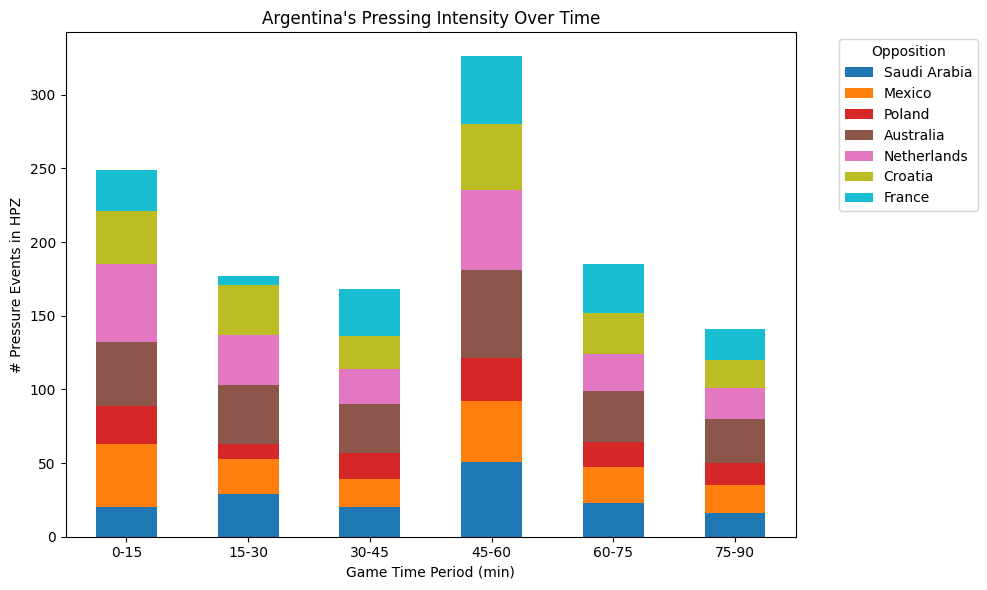

In [ ]:
# Load match summary data
df_argentina = pd.read_csv("argentina_stats.csv")

# Initialize pressure + goal data
pressure_data = []
goal_bins_all_matches = pd.Series(dtype=int)

# Looping through each match
for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    opposition = row["opposition"]
    file_path = f"/content/{match_id}.json"

    # Load event data
    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    # --- PRESSURES ---
    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 17)) &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40)) &
        (df_events["minute"] < 90)
    ].copy()
    df_pressure["minute_bin"] = df_pressure["minute"] // 15 * 15
    pressure_counts = df_pressure.groupby("minute_bin").size().rename(opposition)
    pressure_data.append(pressure_counts)

    # --- GOALS ---
    df_shots = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 16)) &
        (df_events["team"].apply(lambda x: x.get("name") == "Argentina")) &
        (df_events["period"] <= 2)  # normal time only
    ]
    df_goals = df_shots[
        df_shots["shot"].apply(lambda x: isinstance(x, dict) and x.get("outcome", {}).get("name") == "Goal")
    ].copy()
    df_goals["minute_bin"] = df_goals["minute"] // 15 * 15
    goal_bins = df_goals["minute_bin"].value_counts().sort_index()
    goal_bins = goal_bins.reindex(range(0, 90, 15), fill_value=0)
    goal_bins_all_matches = goal_bins_all_matches.add(goal_bins, fill_value=0)

# Create pressure DataFrame
df_pressure_grouped = pd.DataFrame(pressure_data).T.fillna(0)

# --- PLOT ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot stacked pressure bars
ax1 = df_pressure_grouped.plot(kind="bar", stacked=True, colormap="tab10", ax=ax1)
ax1.set_xlabel("Game Time Period (min)")
ax1.set_ylabel("# Pressure Events in HPZ")
ax1.set_title("Argentina's Pressing Intensity Over Time")
ax1.legend(title="Opposition", bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["0-15", "15-30", "30-45", "45-60", "60-75", "75-90"], rotation=0)

# Convert bin labels to position indices
x_pos = list(range(len(goal_bins_all_matches)))
y_vals = goal_bins_all_matches.values

plt.tight_layout()
plt.savefig("pressure_event_count.svg", format="svg")
plt.show()


Changing colors:

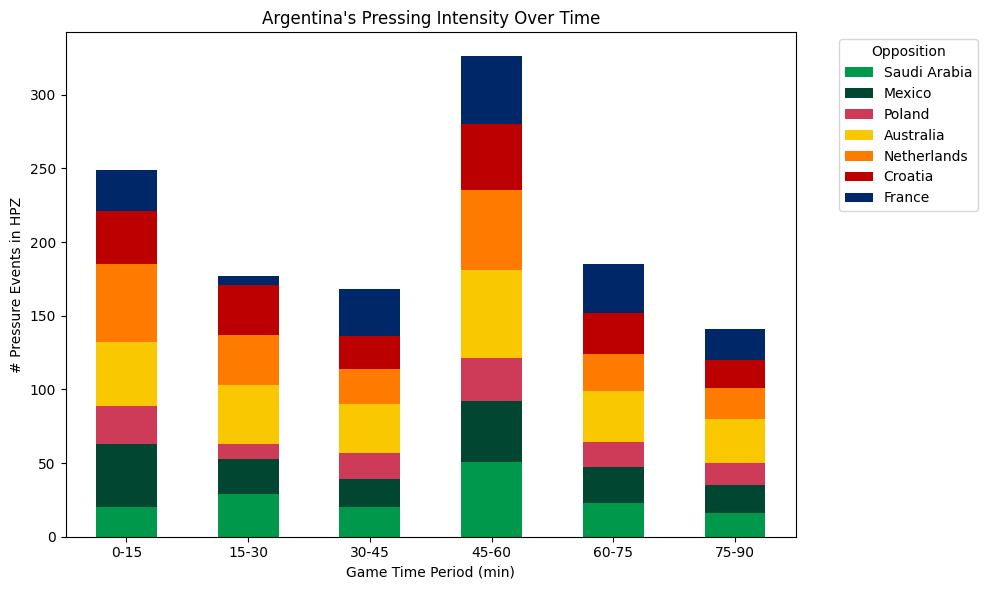

In [ ]:
#Define custom colors for each opponent based on main flag color
opponent_colors = {
    "Saudi Arabia": "#00984a",
    "Mexico": "#004630",
    "Poland": "#cd3b58",
    "Australia": "#fac800",
    "Netherlands": "#ff7b00",
    "Croatia": "#bc0000",
    "France": "#002868",
}

# Create pressure DataFrame
df_pressure_grouped = pd.DataFrame(pressure_data).T.fillna(0)

# Match column order to color order
df_pressure_grouped = df_pressure_grouped[opponent_colors.keys()]

# --- PLOT ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot stacked pressure bars with flag colors
df_pressure_grouped.plot(
    kind="bar",
    stacked=True,
    color=[opponent_colors[team] for team in df_pressure_grouped.columns],
    ax=ax1
)

ax1.set_xlabel("Game Time Period (min)")
ax1.set_ylabel("# Pressure Events in HPZ")
ax1.set_title("Argentina's Pressing Intensity Over Time")
ax1.legend(title="Opposition", bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.set_xticks(range(6))
ax1.set_xticklabels(["0-15", "15-30", "30-45", "45-60", "60-75", "75-90"], rotation=0)

plt.tight_layout()
plt.savefig("pressure_event_count.svg", format="svg")
plt.show()


In [ ]:
plt.tight_layout()
plt.savefig("pressure_event_count.svg", format="svg")

<Figure size 640x480 with 0 Axes>

* **They started the halves with high intensity** up front but afterwards varied the levels differently in each game.

* **They tend to score a lot just before HT and in the middle of the second half**.


### **Total Shots:**

In [ ]:
df_argentina = pd.read_csv("argentina_stats.csv")

# Initialize data containers
pressure_data = []
goal_bins_all_matches = pd.Series(dtype=int)

# New containers for pressing-shot chains
press_shot_counts = pd.Series(dtype=int)
press_xg_sum = pd.Series(dtype=float)
press_goal_count = pd.Series(dtype=int)

# At the top before the loop
total_shots_bin = pd.Series(dtype=int)
total_xg_bin = pd.Series(dtype=float)

# Looping through each match
for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    opposition = row["opposition"]
    file_path = f"/content/{match_id}.json"

    # Load event data
    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    # --- PRESSURES ---
    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 17)) &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40)) &
        (df_events["period"] <= 2)
    ].copy()
    df_pressure["second"] = pd.to_timedelta(df_pressure["timestamp"])
    df_pressure["minute_bin"] = df_pressure["minute"] // 15 * 15
    pressure_counts = df_pressure.groupby("minute_bin").size().rename(opposition)
    pressure_data.append(pressure_counts)

    # --- SHOTS ---
    df_shots = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 16)) &
        (df_events["team"].apply(lambda x: x.get("name") == "Argentina")) &
        (df_events["period"] <= 2)
    ].copy()
    df_shots["second"] = pd.to_timedelta(df_shots["timestamp"])
    df_shots["minute_bin"] = df_shots["minute"] // 15 * 15

        # Count shots per bin
    shot_counts = df_shots["minute_bin"].value_counts()
    total_shots_bin = total_shots_bin.add(shot_counts, fill_value=0)

    # Sum xG per bin
    xg_sums = df_shots.groupby("minute_bin")["shot"].apply(
        lambda x: sum(e.get("statsbomb_xg", 0) for e in x if isinstance(e, dict))
    )
    total_xg_bin = total_xg_bin.add(xg_sums, fill_value=0)


    # --- TOTAL GOALS (normal time) ---
    df_goals = df_shots[
        df_shots["shot"].apply(lambda x: isinstance(x, dict) and x.get("outcome", {}).get("name") == "Goal")
    ].copy()
    goal_bins = df_goals["minute_bin"].value_counts().sort_index()
    goal_bins = goal_bins.reindex(range(0, 90, 15), fill_value=0)
    goal_bins_all_matches = goal_bins_all_matches.add(goal_bins, fill_value=0)


# Fill missing bins
all_bins = range(0, 90, 15)
goal_bins_all_matches = goal_bins_all_matches.reindex(all_bins, fill_value=0)
press_shot_counts = press_shot_counts.reindex(all_bins, fill_value=0)
press_xg_sum = press_xg_sum.reindex(all_bins, fill_value=0)
press_goal_count = press_goal_count.reindex(all_bins, fill_value=0)

# Reindex and round
total_shots_bin = total_shots_bin.reindex(all_bins, fill_value=0).astype(int)
total_xg_bin = total_xg_bin.reindex(all_bins, fill_value=0).round(2)


In [ ]:
# Summary table
df_total_summary = pd.DataFrame({
    "Total Shots": total_shots_bin.astype(int),
    "Total xG": total_xg_bin,
    "Total Goals": goal_bins_all_matches.astype(int)
})

df_total_summary.index = ["0-15", "15-30", "30-45", "45-60", "60-75", "75-90"]

df_total_summary

,Total Shots,Total xG,Total Goals
0-15,8,1.19,1
15-30,9,1.20,1
30-45,20,3.78,5
45-60,12,1.11,2
60-75,18,3.10,4
75-90,9,0.86,1


**Bulk of their shots were taken closer to half-time and midway through the second half**

*But were they a result of high pressing?*

### **Shots after High Pressing:**

In [ ]:
# Load match summary data
df_argentina = pd.read_csv("argentina_stats.csv")

# Initialize data containers
pressure_data = []
goal_bins_all_matches = pd.Series(dtype=int)

# Initializing list to store build-up sequences
build_up_sequences = []

# New containers for pressing-shot chains
press_shot_counts = pd.Series(dtype=int)
press_xg_sum = pd.Series(dtype=float)
press_goal_count = pd.Series(dtype=int)

# Looping through each match
for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    opposition = row["opposition"]
    file_path = f"/content/{match_id}.json"

    # Load event data
    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    # --- PRESSURES ---
    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 17)) &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40)) &
        (df_events["period"] <= 2)
    ].copy()
    df_pressure["second"] = pd.to_timedelta(df_pressure["timestamp"])
    df_pressure["minute_bin"] = df_pressure["minute"] // 15 * 15
    pressure_counts = df_pressure.groupby("minute_bin").size().rename(opposition)
    pressure_data.append(pressure_counts)

    # --- SHOTS ---
    df_shots = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 16)) &
        (df_events["team"].apply(lambda x: x.get("name") == "Argentina")) &
        (df_events["period"] <= 2)
    ].copy()
    df_shots["second"] = pd.to_timedelta(df_shots["timestamp"])
    df_shots["minute_bin"] = df_shots["minute"] // 15 * 15

    # --- TOTAL GOALS (normal time) ---
    df_goals = df_shots[
        df_shots["shot"].apply(lambda x: isinstance(x, dict) and x.get("outcome", {}).get("name") == "Goal")
    ].copy()
    goal_bins = df_goals["minute_bin"].value_counts().sort_index()
    goal_bins = goal_bins.reindex(range(0, 90, 15), fill_value=0)
    goal_bins_all_matches = goal_bins_all_matches.add(goal_bins, fill_value=0)

    # --- PRESSURE-DRIVEN SHOTS  ---
    for _, shot in df_shots.iterrows():
        shot_time = shot["second"]
        shot_period = shot["period"]
        shot_xg = shot["shot"].get("statsbomb_xg", 0) if isinstance(shot["shot"], dict) else 0
        is_goal = isinstance(shot["shot"], dict) and shot["shot"].get("outcome", {}).get("name") == "Goal"
        bin_label = shot["minute_bin"]

        # Filter pressures that occurred before the shot and within 18.4s, same period
        valid_pressures = df_pressure[
            (df_pressure["period"] == shot_period) &
            (df_pressure["second"] <= shot_time) &
            (shot_time - df_pressure["second"] <= pd.Timedelta(seconds=18.4)) &
            (df_pressure["possession"] == shot["possession"])
        ]

        if not valid_pressures.empty:
            press_shot_counts[bin_label] = press_shot_counts.get(bin_label, 0) + 1
            press_xg_sum[bin_label] = press_xg_sum.get(bin_label, 0) + shot_xg
            if is_goal:
                press_goal_count[bin_label] = press_goal_count.get(bin_label, 0) + 1

# Fill missing bins
all_bins = range(0, 90, 15)
goal_bins_all_matches = goal_bins_all_matches.reindex(all_bins, fill_value=0)
press_shot_counts = press_shot_counts.reindex(all_bins, fill_value=0)
press_xg_sum = press_xg_sum.reindex(all_bins, fill_value=0)
press_goal_count = press_goal_count.reindex(all_bins, fill_value=0)

In [ ]:
# Creating summary DataFrame
df_summary = pd.DataFrame({
    "Shots After Pressure": press_shot_counts.astype(int),
    "xG After Pressure": press_xg_sum.round(2),
    "Goals After Pressure": press_goal_count.astype(int),
    "Total Goals": goal_bins_all_matches.astype(int)
})

# Setting bin labels for clarity
df_summary.index = ["0-15", "15-30", "30-45", "45-60", "60-75", "75-90"]

# Displaying the table
df_summary

,Shots After Pressure,xG After Pressure,Goals After Pressure,Total Goals
0-15,4,0.30,0,1
15-30,1,0.01,0,1
30-45,5,0.86,1,5
45-60,7,0.65,2,2
60-75,5,0.56,1,4
75-90,2,0.23,0,1


In [ ]:
# Merging pressure-driven shot summary with total shot summary
df_combined = df_summary.copy()
df_combined["Total Shots"] = df_total_summary["Total Shots"]
df_combined["Total xG"] = df_total_summary["Total xG"]

df_combined


,Shots After Pressure,xG After Pressure,Goals After Pressure,Total Goals,Total Shots,Total xG
0-15,4,0.30,0,1,8,1.19
15-30,1,0.01,0,1,9,1.20
30-45,5,0.86,1,5,20,3.78
45-60,7,0.65,2,2,12,1.11
60-75,5,0.56,1,4,18,3.10
75-90,2,0.23,0,1,9,0.86


In [ ]:
df_combined.to_csv("arg_shots_summary.csv", index=True)

**31.58% of the total shots (24/76) taken by Argentina happened within 18.4 seconds from an occurrence of a high pressure event**. They scored 4 goals from them; about 28.57% of their tournament total.

Most of those shots were taken at the beginning of the second half (45-60 min) which also happens to be the period in which the pressed the most overall in the tournament.

So, they **choose their moments to press high, and if they win the ball, they often build up quickly to take a shot. They're not all-out pressers, but they are deliberate and under control when they do press**.

Goal conversion from pressure-driven shots is modest but meaningful with goals scored against Poland, Australia, Netherlands and Croatia. These are high-leverage matches where Argentina pressed effectively when it mattered most.

In [ ]:
print("\n DEBUG: Pressure-Driven Shots Breakdown (18.4s window)\n")

for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    opposition = row["opposition"]
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    df_pressure = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 17)) &
        (df_events["location"].apply(lambda loc: isinstance(loc, list) and loc[0] > 40)) &
        (df_events["period"] <= 2)
    ].copy()
    df_pressure["second"] = pd.to_timedelta(df_pressure["timestamp"])

    df_shots = df_events[
        (df_events["type"].apply(lambda x: x.get("id") == 16)) &
        (df_events["team"].apply(lambda x: x.get("name") == "Argentina")) &
        (df_events["period"] <= 2)
    ].copy()
    df_shots["second"] = pd.to_timedelta(df_shots["timestamp"])
    df_shots["minute_bin"] = df_shots["minute"] // 15 * 15

    print(f"📂 Match: {match_id} vs {opposition}")

    for _, shot in df_shots.iterrows():
        shot_time = shot["second"]
        shot_period = shot["period"]
        bin_label = shot["minute_bin"]
        xg = shot["shot"].get("statsbomb_xg", 0) if isinstance(shot["shot"], dict) else None
        is_goal = isinstance(shot["shot"], dict) and shot["shot"].get("outcome", {}).get("name") == "Goal"

        valid_pressures = df_pressure[
            (df_pressure["period"] == shot_period) &
            (df_pressure["second"] <= shot_time) &
            (shot_time - df_pressure["second"] <= pd.Timedelta(seconds=18.4)) &
            (df_pressure["possession"] == shot["possession"])
        ]

        if not valid_pressures.empty:
            matched_pressure = valid_pressures.iloc[-1]  # use latest
            time_gap = (shot_time - matched_pressure["second"]).total_seconds()
            print(f"→ Minute: {shot['minute']}, Bin: {bin_label}, xG: {xg:.3f}, Goal: {is_goal}")
            print(f"   Shot Time: {shot['timestamp']} | Pressure Time: {matched_pressure['timestamp']} | Δ = {time_gap:.1f}s")
            print("---")


## **Training an Expected Threat Model:**

Downloading all non-Argentina related data first:


In [ ]:
# Downloading match list for 2022 World Cup
match_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/43/106.json"
matches = requests.get(match_url).json()

# Filtering out matches involving Argentina
non_arg_matches = [
    m for m in matches
    if m.get("home_team", {}).get("name") != "Argentina"
    and m.get("away_team", {}).get("name") != "Argentina"
]

# Initializing event storage
all_events = []

# Looping through each non-Argentina match
for match in tqdm(non_arg_matches):
    match_id = match["match_id"]
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"

    # Downloading event data for match
    events = requests.get(url).json()

    # Filtering out events by Argentina
    filtered = [e for e in events if e.get("team", {}).get("name") != "Argentina"]

    # Appending to event list
    all_events.extend(filtered)

# Saving filtered events to JSON file
with open("non_argentina_worldcup_events.json", "w") as f:
    json.dump(all_events, f)


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


In [ ]:
# Saving to compressed JSON Lines file
with gzip.open("non_argentina_worldcup_events.jsonl.gz", "wt", encoding="utf-8") as f:
    for event in all_events:
        f.write(json.dumps(event) + "\n")


In [ ]:
# Checking for Argentina-related events
with gzip.open("non_argentina_worldcup_events.jsonl.gz", "rt", encoding="utf-8") as f:
    for i, line in enumerate(f):
        event = json.loads(line)
        team_name = event.get("team", {}).get("name", "")
        possession_team = event.get("possession_team", {}).get("name", "")
        if "Argentina" in [team_name, possession_team]:
            print(f"Line {i}: Found Argentina - team: {team_name}, possession_team: {possession_team}")
            break
    else:
        print("No Argentina-related events found.")


Line 3211: Found Argentina - team: Australia, possession_team: Argentina


### **World Cup xT Heatmap from Rest of the Teams:**

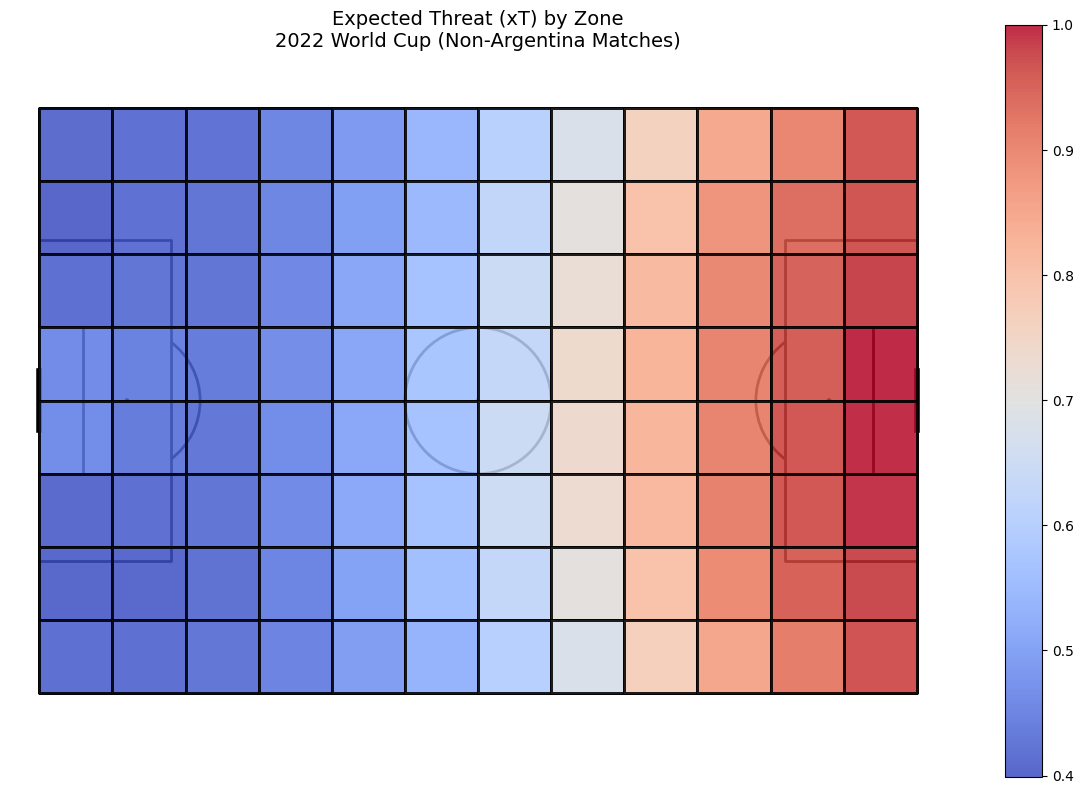

In [ ]:
# Loading StatsBomb event data
with gzip.open('non_argentina_worldcup_events.jsonl.gz', 'rt', encoding='utf-8') as f:
    events = [json.loads(line) for line in f]

# Extracting passes and carries with start & end locations
data = []
for event in events:
    if event['type']['name'] in ['Pass', 'Carry']:
        action = event[event['type']['name'].lower()]
        if event.get('location') and action.get('end_location'):
            start = event['location']
            end = action['end_location']
            data.append((start[0], start[1], end[0], end[1]))

df = pd.DataFrame(data, columns=['start_x', 'start_y', 'end_x', 'end_y'])

# Binning pitch into zones
x_bins, y_bins = 12, 8
df['start_x_bin'] = pd.cut(df['start_x'], bins=np.linspace(0, 120, x_bins + 1), labels=False, include_lowest=True)
df['start_y_bin'] = pd.cut(df['start_y'], bins=np.linspace(0, 80, y_bins + 1), labels=False, include_lowest=True)
df['end_x_bin'] = pd.cut(df['end_x'], bins=np.linspace(0, 120, x_bins + 1), labels=False, include_lowest=True)
df['end_y_bin'] = pd.cut(df['end_y'], bins=np.linspace(0, 80, y_bins + 1), labels=False, include_lowest=True)

# Counting zone transitions
transition_counts = defaultdict(int)
zone_counts = defaultdict(int)
for _, row in df.iterrows():
    start_zone = (row['start_x_bin'], row['start_y_bin'])
    end_zone = (row['end_x_bin'], row['end_y_bin'])
    if None not in start_zone + end_zone:
        transition_counts[(start_zone, end_zone)] += 1
        zone_counts[start_zone] += 1

# Calculating transition probabilities
transition_matrix = defaultdict(float)
for (start, end), count in transition_counts.items():
    transition_matrix[(start, end)] = count / zone_counts[start]

# Initializing xT values (all zero)
xt = { (x, y): 0.0 for x in range(x_bins) for y in range(y_bins) }

# Assigning goal area zones high value (terminal reward)
for x in range(x_bins - 2, x_bins):
    for y in range(y_bins // 3, 2 * y_bins // 3):
        xt[(x, y)] = 1.0

# Iterative propagation of xT values (Markov-style)
for _ in range(30):
    new_xt = xt.copy()
    for (start, end), prob in transition_matrix.items():
        new_xt[start] += prob * xt[end]
    xt = new_xt
    max_xt = max(xt.values())
    xt = {k: v / max_xt for k, v in xt.items()}


# Convert xt dictionary to a 2D grid array
xt_grid = np.zeros((x_bins, y_bins))
for x in range(x_bins):
    for y in range(y_bins):
        xt_grid[x, y] = xt[(x, y)]

xt_grid = xt_grid / xt_grid.max()

# Rotate the grid so that it matches the horizontal pitch layout
xt_grid_rotated = xt_grid.T[::-1]

# Create grid edges matching the pitch dimensions.
x_edges = np.linspace(0, 120, x_bins + 1)
y_edges = np.linspace(0, 80, y_bins + 1)

# Draw the pitch and plot the heatmap using mplsoccer's Pitch
pitch = Pitch(
    pitch_type='statsbomb',
    pitch_length=120,
    pitch_width=80,
    line_color='black',
    pitch_color='white'
)
fig, ax = pitch.draw(figsize=(12, 8))

# Create the heatmap and capture the QuadMesh object
hm = pitch.heatmap(
    {'statistic': xt_grid_rotated, 'x_grid': x_edges, 'y_grid': y_edges},
    ax=ax,
    cmap='coolwarm',
    edgecolors='black',
    alpha=0.85,    # Adjusts transparency (0=transparent, 1=opaque)
    zorder=1
)

# Manually adding a colorbar using the returned QuadMesh
fig.colorbar(hm, ax=ax)

ax.text(0.5, 1.05, 'Expected Threat (xT) by Zone\n2022 World Cup (Non-Argentina Matches)',
        transform=ax.transAxes, ha='center', fontsize=14)


# Convert to serializable format
xt_json = []
for (x, y), value in xt.items():
    xt_json.append({
        "x_bin": int(x),
        "y_bin": int(y),
        "xT": round(float(value), 5)  # Optional rounding
    })

# Save as JSON
with open("xt_values.json", "w") as f:
    json.dump(xt_json, f, indent=2)

plt.show()

## **Argentina's Build-up Success:**

*How did they try to score with the ball in general?*

This gives an idea of how Argentina progressed their ball to get into goal scoring locations in each game.

Only chains (sequences) with at least 3 passes/progressive carries from defense zone to attack zone are considered.

Each chain basically indicates how Argentina moved the ball from a less dangerous area of the pitch to a more dangerous one.

In [ ]:
# Initialize storage
build_up_sequences = []

# Loop through each match
for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    file_path = f"/content/{match_id}.json"

    # Load event data
    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    # Filter only Argentina's events in normal time
    df_events = df_events[
        (df_events["team"].apply(lambda x: x.get("name") == "Argentina")) &
        (df_events["period"] <= 2)
    ]

    # Extracting coordinates for passes and carries
    df_events["start_x"] = df_events["location"].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    df_events["start_y"] = df_events["location"].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    df_events["end_x"] = df_events.apply(
        lambda row: row["pass"]["end_location"][0] if row["type"]["id"] == 30 and isinstance(row.get("pass"), dict) else
                    row["carry"]["end_location"][0] if row["type"]["id"] == 43 and isinstance(row.get("carry"), dict) else None,
        axis=1
    )
    df_events["end_y"] = df_events.apply(
        lambda row: row["pass"]["end_location"][1] if row["type"]["id"] == 30 and isinstance(row.get("pass"), dict) else
                    row["carry"]["end_location"][1] if row["type"]["id"] == 43 and isinstance(row.get("carry"), dict) else None,
        axis=1
    )

    # Loop through possessions
    for possession_id in df_events["possession"].unique():
        df_pos = df_events[df_events["possession"] == possession_id].copy()

        # Get passes
        passes = df_pos[df_pos["type"].apply(lambda x: x["id"] == 30)]

        # Get progressive carries (≥10m forward)
        carries = df_pos[
            (df_pos["type"].apply(lambda x: x["id"] == 43)) &
            (df_pos["end_x"] - df_pos["start_x"] >= 10)
        ]

        # Combine and sort by index (event order)
        moves = pd.concat([passes.assign(type_move="pass"), carries.assign(type_move="carry")])
        moves = moves.sort_index()

        # Check if Messi was involved in the possession
        messi_involved = df_pos["player"].apply(
            lambda p: isinstance(p, dict) and p.get("name") == "Lionel Andrés Messi Cuccittini"
        ).any()

        # Skip if fewer than 3 total moves
        if len(moves) < 3:
            continue

        # Check if first move started in defensive third
        first = moves.iloc[0]
        if first["start_x"] is None or first["start_x"] > 33:
            continue

        # Check if last move ended in final third
        last = moves.iloc[-1]
        if last["end_x"] is None or last["end_x"] < 80:
            continue

        # Classify zone based on first move
        y = first["start_y"]
        if y is None:
            continue
        if y < 26.7:
            zone = "left"
        elif y > 53.3:
            zone = "right"
        else:
            zone = "central"

        # Store sequence
        build_up_sequences.append({
            "match_id": match_id,
            "possession_id": possession_id,
            "start_zone": zone,
            "messi_involved": int(messi_involved),
            "moves": moves[["type_move", "start_x", "start_y", "end_x", "end_y"]].to_dict("records")
        })


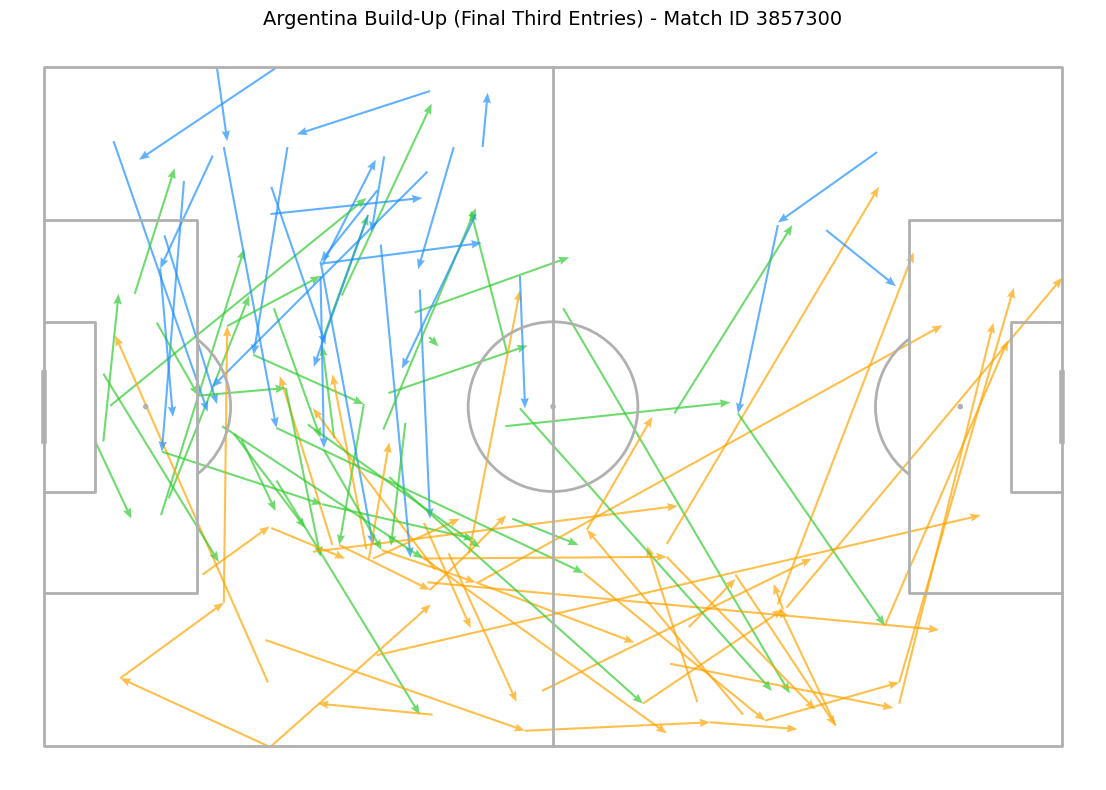

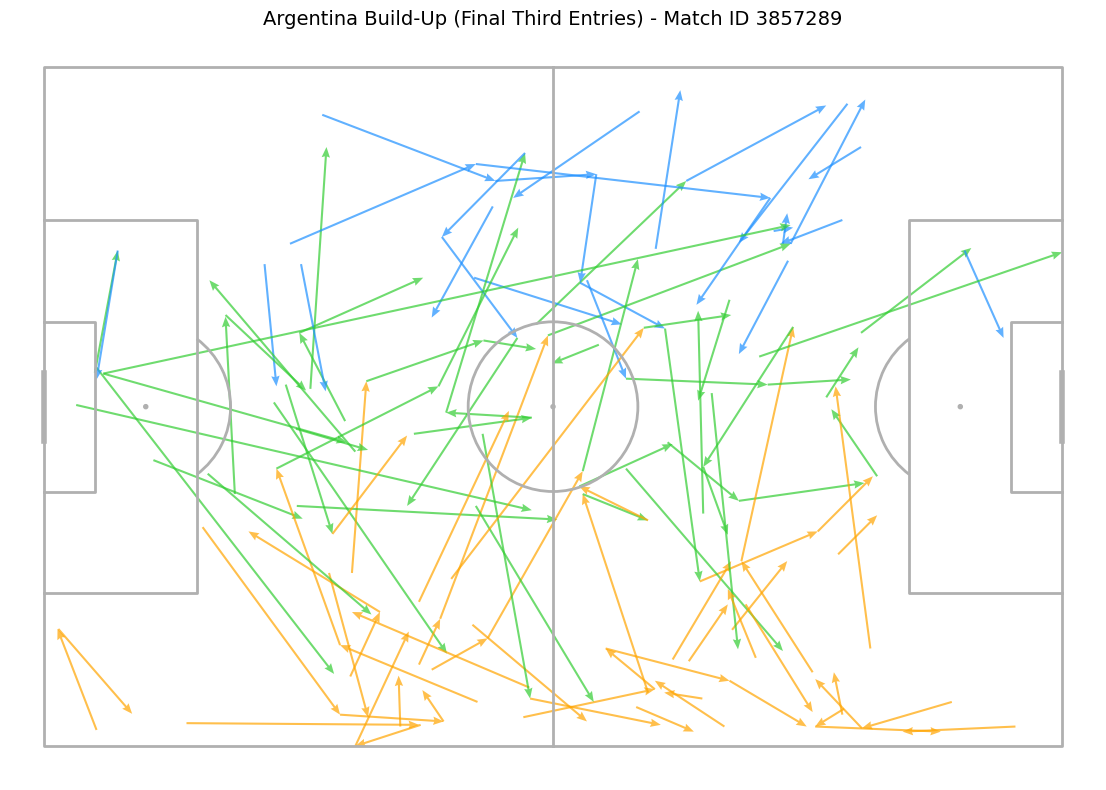

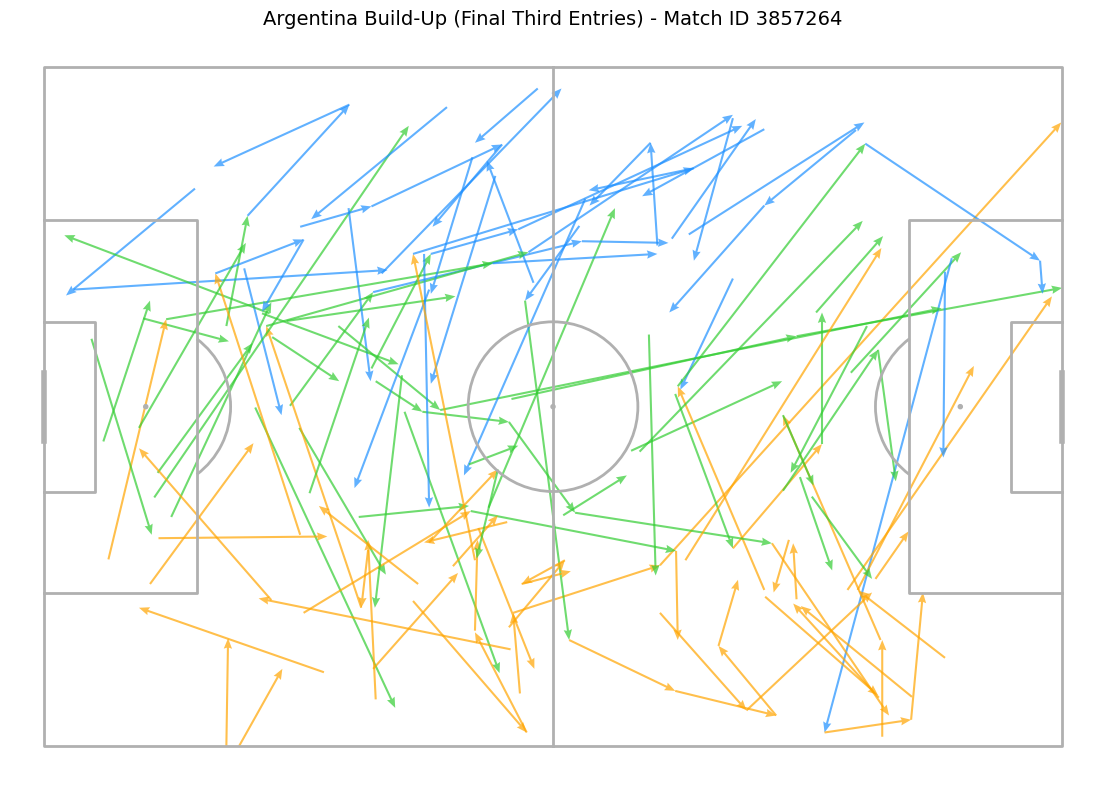

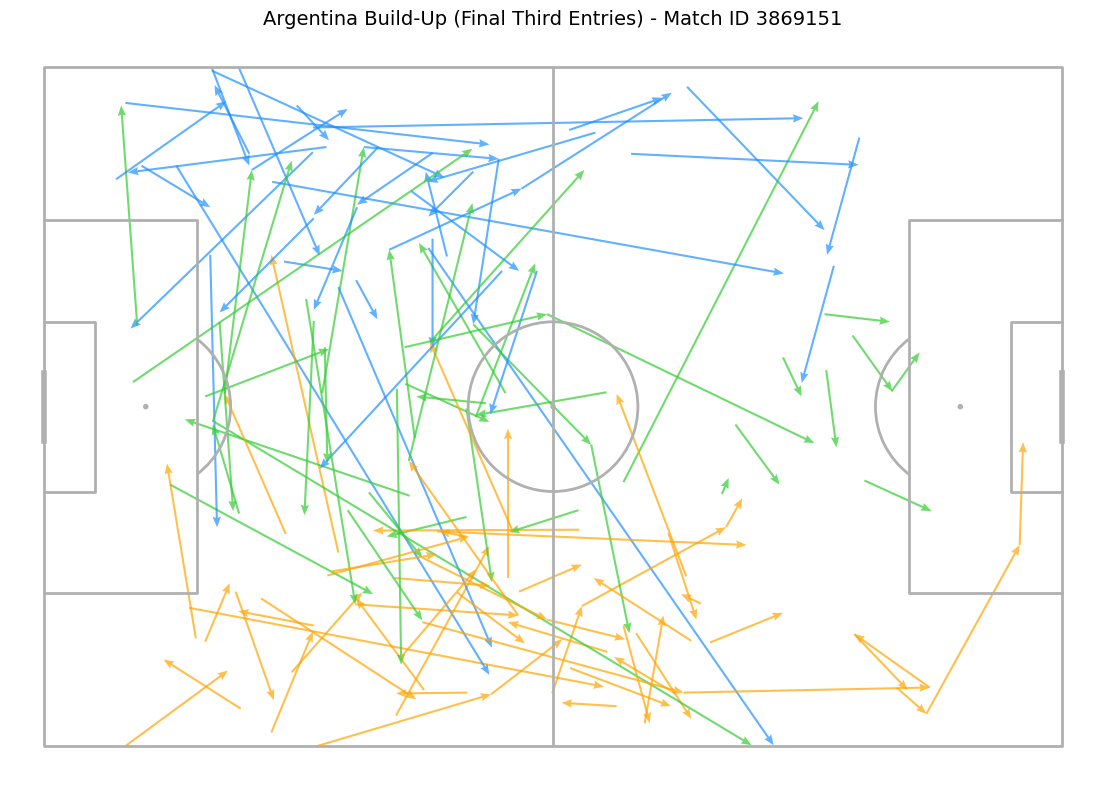

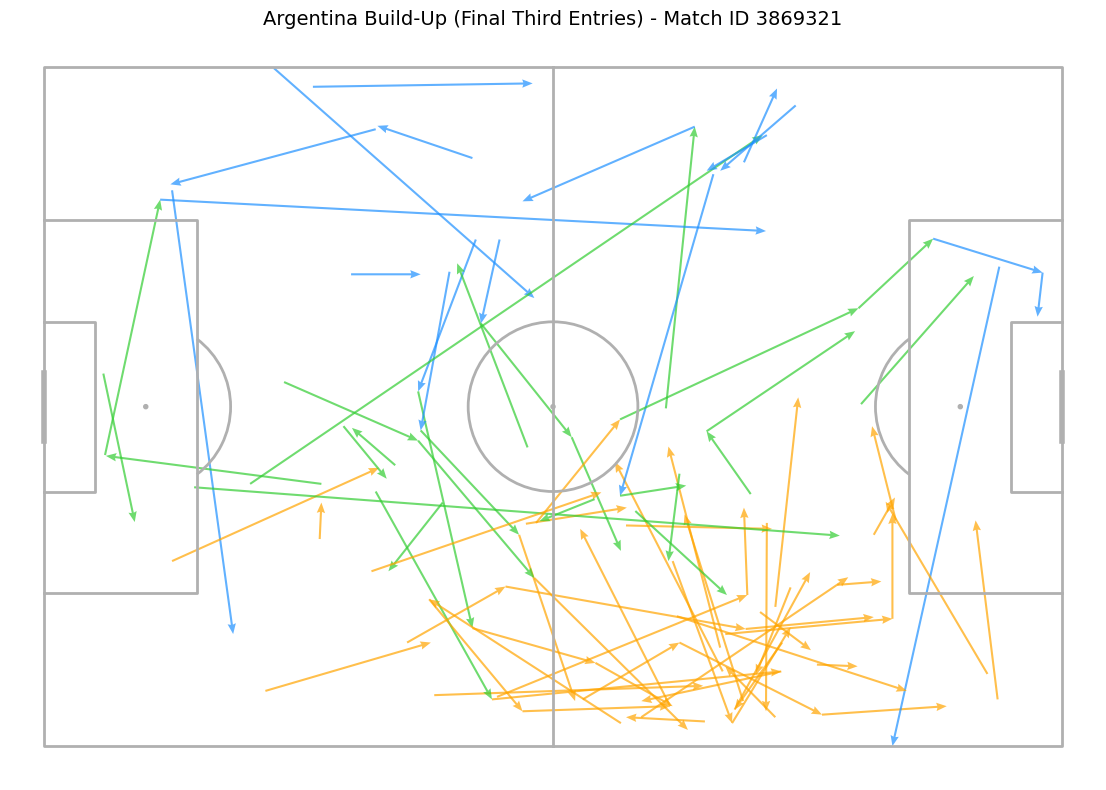

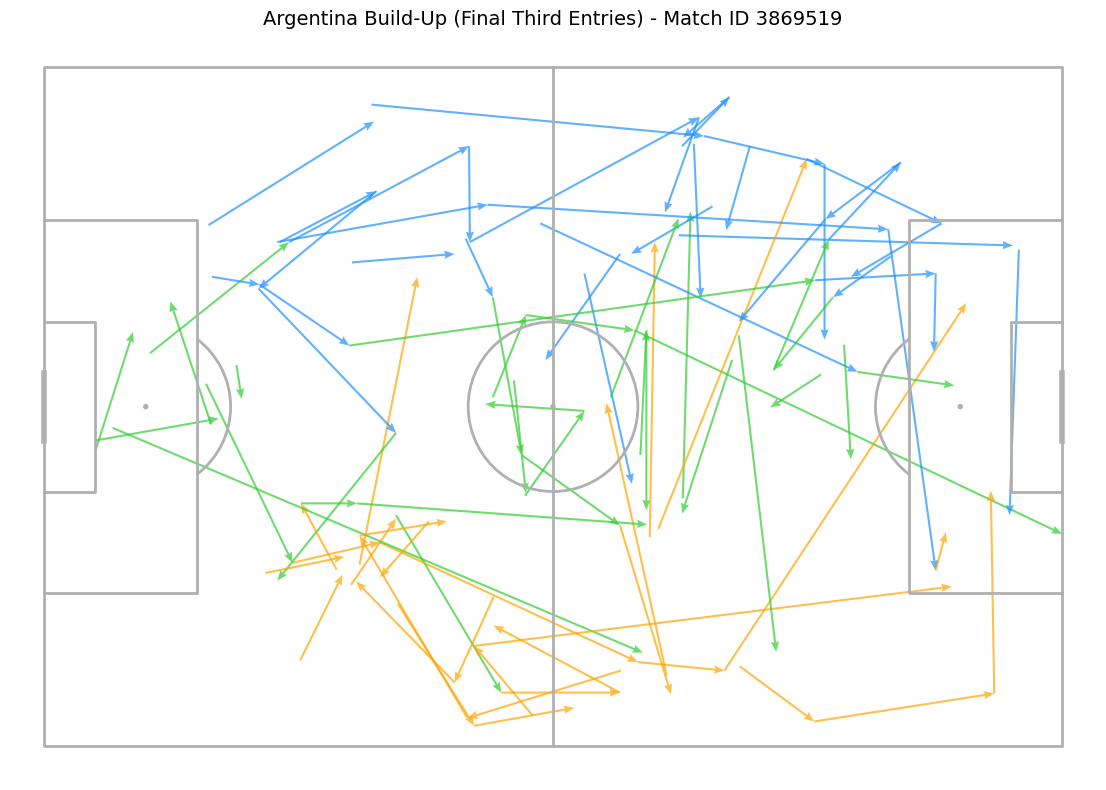

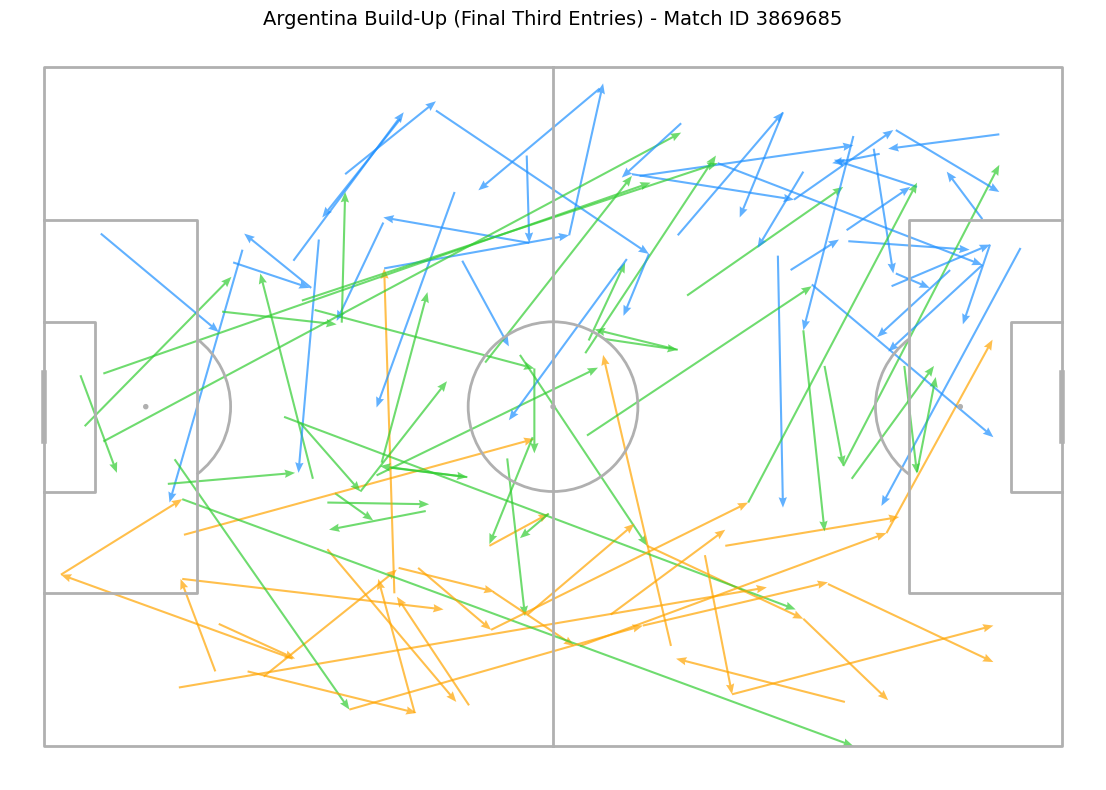

In [ ]:
# Creating output directory
os.makedirs("build_up_visuals", exist_ok=True)

# Looping through matches in order
match_ids = df_argentina["match_id"].tolist()

for match_id in match_ids:
    # Filtering sequences for the match
    sequences = [seq for seq in build_up_sequences if seq["match_id"] == match_id]

    # Loading event data for orientation
    file_path = f"/content/{match_id}.json"
    with open(file_path, "r") as f:
        df_events = pd.DataFrame(json.load(f))

    # Flipping check based on first event
    first_event = df_events.iloc[0]
    first_x = first_event["location"][0] if isinstance(first_event["location"], list) else None
    flip_x = first_x and first_x > 60

    # Initializing pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
    fig, ax = pitch.draw(figsize=(12, 8))

    # Plotting all moves in each sequence
    for seq in sequences:
        for m in seq["moves"]:
            x1 = 120 - m["start_x"] if flip_x else m["start_x"]
            y1 = m["start_y"]
            x2 = 120 - m["end_x"] if flip_x else m["end_x"]
            y2 = m["end_y"]

            # Skipping incomplete coordinates
            if None in [x1, y1, x2, y2]:
                continue

            # Color by vertical start zone
            if y1 < 26.7:
                color = "dodgerblue"
            elif y1 > 53.3:
                color = "orange"
            else:
                color = "limegreen"

            # Drawing arrow
            pitch.arrows(x1, y1, x2, y2, ax=ax, width=1.5, headwidth=4, color=color, alpha=0.7)

    # Setting title and saving
    plt.title(f'Argentina Build-Up (Final Third Entries) - Match ID {match_id}', fontsize=14)
    # plt.savefig(f"build_up_visuals/build_up_{match_id}.png", dpi=300, bbox_inches='tight')
    plt.show()


An arrow represents an attempt made by Argentina towards eventually moving the ball higher up the pitch.

Each arrow belongs to a chain. Some are at the start of a chain, some at the middle and some at the end.

Every single arrow is color coded by its starting position on the pitch (different colored arrows can be a part of a single chain).

*How impactful were these chains?*

In [ ]:
# Function to bin coordinates into xT grid zones
def get_zone(x, y, x_bins=12, y_bins=8, pitch_length=120, pitch_width=80):
    if x is None or y is None:
        return None
    x_bin = int(np.clip(x / pitch_length * x_bins, 0, x_bins - 1))
    y_bin = int(np.clip(y / pitch_width * y_bins, 0, y_bins - 1))
    return (x_bin, y_bin)

# Creating DataFrame with xT and action counts
records = []

for seq in build_up_sequences:
    total_xt = 0
    num_passes = 0
    num_carries = 0

    for move in seq["moves"]:
        start_zone = get_zone(move["start_x"], move["start_y"])
        end_zone = get_zone(move["end_x"], move["end_y"])
        if start_zone is None or end_zone is None:
            continue
        xt_gain = xt.get(end_zone, 0) - xt.get(start_zone, 0)
        total_xt += xt_gain

        # Counting action types
        if move["type_move"] == "pass":
            num_passes += 1
        elif move["type_move"] == "carry":
            num_carries += 1

    records.append({
        "match_id": seq["match_id"],
        "possession_id": seq["possession_id"],
        "messi_involved": seq["messi_involved"],
        "start_zone": seq["start_zone"],
        "total_xt_gain": total_xt,
        "num_passes": num_passes,
        "num_carries": num_carries
    })

df_xt_gain = pd.DataFrame(records)

In [ ]:
Counter([seq["messi_involved"] for seq in build_up_sequences])


Counter({1: 62, 0: 12})

**Out of 74 chains, 62 of them involved Messi!**

In [ ]:
avg_xt = df_xt_gain.groupby("messi_involved")["total_xt_gain"].mean().reset_index()

plt.figure(figsize=(6, 4))
ax=sns.barplot(data=avg_xt, x="messi_involved", y="total_xt_gain", hue="messi_involved", palette=["grey", "gold"], dodge=False)
ax.get_legend().remove()
plt.title("Avg xT Gained per Build-Up Chain\nWith vs Without Messi")
plt.ylabel("Average xT Gain")
plt.xlabel("Messi Involved in Build-Up")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()


In [ ]:
avg_xt.to_json('xt_messi.json', orient='records', lines=True)
avg_xt

,messi_involved,total_xt_gain
0,0,0.436417
1,1,0.511634


**It** means Argentina — with Messi in the build-up — reached positions where the chance of scoring was **~17% higher** on average!

In [ ]:
df_xt_gain

,match_id,possession_id,messi_involved,start_zone,total_xt_gain
0,3857300,14,1,central,0.495316
1,3857300,27,0,left,0.387938
2,3857300,65,1,central,0.457196
3,3857300,99,1,left,0.633802
4,3857300,101,0,central,0.496284
...,...,...,...,...,...
69,3869685,125,1,central,0.535804
70,3869685,139,1,central,0.339092
71,3869685,188,1,right,0.526813
72,3869685,191,1,central,0.303243


A chain with x moves (passes/proggressive carries) **involving him** from the Netherlands game tops the list as it improved Argentina's chances of scoring by **99.04%**

The highest threat gain they achieved **without him involved** was **57.08%** from a chain with y moves against Saudi Arabia.

*How much impact did he have on Argentina's finishing?*

In [ ]:
# Initialize storage
messi_shots = []
non_messi_shots = []

for _, row in df_argentina.iterrows():
    match_id = row["match_id"]
    file_path = f"/content/{match_id}.json"

    with open(file_path, "r") as f:
        event_data = json.load(f)
    df_events = pd.DataFrame(event_data)

    # Filter shot events only
    shots = df_events[df_events["type"].apply(lambda x: x["name"] == "Shot")]

    for _, shot in shots.iterrows():
        player_name = shot["player"]["name"] if isinstance(shot.get("player"), dict) else None
        xg = shot["shot"]["statsbomb_xg"] if isinstance(shot.get("shot"), dict) else None
        outcome = shot["shot"]["outcome"]["name"] if isinstance(shot.get("shot"), dict) else None
        location = shot["location"] if isinstance(shot.get("location"), list) else None
        shot_type = shot["shot"]["type"]["name"] if isinstance(shot.get("shot"), dict) else None

        # Skip penalty shootouts
        if shot_type == "Penalty":
            continue

        shot_data = {
            "match_id": match_id,
            "player": player_name,
            "xG": xg,
            "outcome": outcome,
            "location": location,
            "shot_type": shot_type
        }

        if player_name and "Messi" in player_name:
            messi_shots.append(shot_data)
        else:
            non_messi_shots.append(shot_data)

# Convert to DataFrames
df_messi_shots = pd.DataFrame(messi_shots)
df_non_messi_shots = pd.DataFrame(non_messi_shots)


In [ ]:
# Convert xG to float and drop NaNs
df_messi_shots["xG"] = pd.to_numeric(df_messi_shots["xG"], errors="coerce")
df_non_messi_shots["xG"] = pd.to_numeric(df_non_messi_shots["xG"], errors="coerce")

# Calculate stats for Messi
messi_total_xg = df_messi_shots["xG"].sum()
messi_goals = (df_messi_shots["outcome"] == "Goal").sum()
messi_conversion = messi_goals / messi_total_xg if messi_total_xg > 0 else 0

# Calculate stats for non-Messi
non_messi_total_xg = df_non_messi_shots["xG"].sum()
non_messi_goals = (df_non_messi_shots["outcome"] == "Goal").sum()
non_messi_conversion = non_messi_goals / non_messi_total_xg if non_messi_total_xg > 0 else 0

# Show results
print("Messi:")
print(f"  Shots: {len(df_messi_shots)}")
print(f"  Goals: {messi_goals}")
print(f"  Total xG: {messi_total_xg:.2f}")
print(f"  Conversion rate (Goals/xG): {messi_conversion:.2f}")

print("\nNon-Messi Argentina:")
print(f"  Shots: {len(df_non_messi_shots)}")
print(f"  Goals: {non_messi_goals}")
print(f"  Total xG: {non_messi_total_xg:.2f}")
print(f"  Conversion rate (Goals/xG): {non_messi_conversion:.2f}")


Messi:
  Shots: 27
  Goals: 3
  Total xG: 2.11
  Conversion rate (Goals/xG): 1.42

Non-Messi Argentina:
  Shots: 112
  Goals: 13
  Total xG: 10.57
  Conversion rate (Goals/xG): 1.23


Messi did finish better than his teammates but only slightly. Others outperformed their xG too!

*How do they compare with other teams?*

In [ ]:
# Load all non-Argentina WC event data
with gzip.open("/content/non_argentina_worldcup_events.jsonl.gz", "rt", encoding="utf-8") as f:
    events = [json.loads(line) for line in f]

# Storage
team_stats = defaultdict(lambda: {"shots": 0, "goals": 0, "xG": 0.0})

# Process events
for event in events:
    if event.get("type", {}).get("name") != "Shot":
        continue

    shot = event.get("shot", {})
    shot_type = shot.get("type", {}).get("name")
    if shot_type == "Penalty":
        continue  # exclude penalties

    xg = shot.get("statsbomb_xg")
    outcome = shot.get("outcome", {}).get("name")
    team = event.get("team", {}).get("name")

    if xg is None or team is None:
        continue

    team_stats[team]["shots"] += 1
    team_stats[team]["xG"] += float(xg)
    if outcome == "Goal":
        team_stats[team]["goals"] += 1

# Convert to DataFrame
df_team_stats = pd.DataFrame([
    {
        "team": team,
        "shots": stats["shots"],
        "goals": stats["goals"],
        "xG": stats["xG"],
        "conversion_rate": stats["goals"] / stats["xG"] if stats["xG"] > 0 else 0
    }
    for team, stats in team_stats.items()
])

df_team_stats = df_team_stats.sort_values(by="conversion_rate", ascending=False)


In [ ]:
df_team_stats

,team,shots,goals,xG,conversion_rate
20,Spain,47,8,3.970627,2.014795
8,Netherlands,43,10,4.993787,2.002488
28,Ghana,24,5,2.569753,1.945712
2,Australia,26,3,1.578172,1.900934
11,Portugal,64,10,5.745710,1.740429
18,England,61,12,7.168856,1.673907
25,Costa Rica,11,2,1.234112,1.620598
1,Serbia,32,5,3.090398,1.617915
10,South Korea,48,5,3.604595,1.387118
13,France,100,14,10.254858,1.365207


Argentina's conversion rate (including Messi) without penalties is about 1.26 . So they score just a little more than what they were expected to score from the chances they created.

However, they took the most shots (139) and scored the most non-penalty goals (16) in the entire tournament!

# **Argentina's In-game Management**

*How did Argentina's coaching team manage to adapt during games?*

In [ ]:
# Loading Argentina match list
df_argentina = pd.read_csv("argentina_stats.csv")

# Filtering for required  games
target_opponents = ["Saudi Arabia", "Australia", "Netherlands", "France"]
target_matches = df_argentina[df_argentina["opposition"].isin(target_opponents)]

# Creating containers for outputs
events_dict = {}
subs = {}
tactical_shifts = {}

# Looping through target matches
for _, row in target_matches.iterrows():
    match_id = row["match_id"]
    opponent = row["opposition"]
    file_path = f"/content/{match_id}.json"

    # Loading event data
    with open(file_path, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)

    # Storing all events
    events_dict[opponent]=df

    # Filtering substitutions
    subs[opponent] = df[df["type"].apply(lambda x: x["name"]) == "Substitution"]

    # Filtering tactical shifts
    tactical_shifts[opponent] = df[df["type"].apply(lambda x: x["name"]) == "Tactical Shift"]

In [ ]:
# Creating a goal timeline for Argentina matches
goals = {}

for opponent, df in events_dict.items():
    goals[opponent] = []

    for _, row in df.iterrows():
        if row["type"]["name"] == "Shot":
            outcome = row.get("shot", {}).get("outcome", {}).get("name")
            if outcome == "Goal":
                minute = row["minute"]
                if minute > 120:
                    continue  # Skipping penalty shootout goals
                player = row.get("player", {}).get("name", "Unknown")
                team = row.get("team", {}).get("name", "Unknown")
                goals[opponent].append((minute, f"⏱ {minute}’ — Goal\n⚽ {player} ({team})"))


In [ ]:
tooltips = {}

for opponent in subs.keys():
    tooltips[opponent] = []

    # Getting starting formation
    start_xi = events_dict[opponent]
    start_event = start_xi[start_xi["type"].apply(lambda x: x["name"]) == "Starting XI"]
    starting_formation = start_event.iloc[0].get("tactics", {}).get("formation", "Unknown")
    last_formation = starting_formation

    # Substitution tooltips
    for _, row in subs[opponent].iterrows():
        minute = row["minute"]
        team_name = row.get("team", {}).get("name", "Unknown")

        def get_sub_on_position_from_shift(player_id, minute, tactical_df, max_checks=3):
            # Looping through shifts after the sub
            shifts_after = tactical_df[tactical_df["minute"] >= minute].sort_values("minute").head(max_checks)

            for _, row in shifts_after.iterrows():
                lineup = row.get("tactics", {}).get("lineup", [])
                for p in lineup:
                    if p["player"]["id"] == player_id:
                        return p["position"]["name"]

            # If not found in any lineup
            return "Unknown"

        player_off = row["player"]["name"]
        pos_off = row.get("position", {}).get("name", "Unknown")

        player_on = row.get("substitution", {}).get("replacement", {}).get("name", "Unknown")
        player_on_id = row.get("substitution", {}).get("replacement", {}).get("id")

        #Debugging
        if player_on_id is None:
            print(f"[DEBUG] No ID found for player_on: {player_on}")

        found = False
        position_found = False

        for _, shift_row in tactical_shifts[opponent].iterrows():
            lineup = shift_row.get("tactics", {}).get("lineup", [])
            for p in lineup:
                if p["player"]["id"] == player_on_id:
                    found = True
                    if "position" in p and p["position"] and "name" in p["position"]:
                        position_found = True
                    break
            if found:
                break

        if not found:
            print(f"[DEBUG] {player_on} never appears in tactics.lineup after {minute}′ in {opponent}")
        elif not position_found:
            print(f"[DEBUG] {player_on} is in lineup but has no position after {minute}′ in {opponent}")


        pos_on = get_sub_on_position_from_shift(player_on_id, minute, tactical_shifts[opponent], max_checks=3)
        if pos_on == "Unknown":
            print(f"[DEBUG] Position missing for {player_on} at {minute}′ in {opponent}")

        reason = row.get("substitution", {}).get("outcome", {}).get("name", "Unknown")

        # Classifying sub type from incoming player’s position
        if pos_on in [
            "Goalkeeper", "Right Back", "Right Center Back", "Center Back", "Left Center Back",
            "Left Back", "Right Wing Back", "Left Wing Back"
        ]:
            sub_type = "🛡 Defensive sub"
        elif pos_on in [
            "Right Defensive Midfield", "Center Defensive Midfield", "Left Defensive Midfield",
            "Right Midfield", "Right Center Midfield", "Center Midfield", "Left Center Midfield",
            "Left Midfield"
        ]:
            sub_type = "⚙️ Midfield sub"
        elif pos_on in [
            "Right Wing", "Left Wing", "Secondary Striker", "Striker",
            "Right Center Forward", "Left Center Forward","Center Forward",
            "Right Attacking Midfield", "Center Attacking Midfield", "Left Attacking Midfield"
        ]:
            sub_type = "⚔️ Attacking sub"
        else:
            sub_type = "❓ Unknown role"

        if sub_type == "❓ Unknown role":
            print(f"[DEBUG] Role not classified → {player_on} = {pos_on} in {opponent}")


        tooltip = (
            f"⏱ {minute}’ — Substitution by {team_name}\n"
            f"🔄 {player_off} ({pos_off}) → {player_on} ({pos_on})\n"
            f"🧭 Type: {sub_type}\n"
            f"🎯 Reason: {reason}"
        )

        tooltips[opponent].append((minute, tooltip))


      # Initializing last known formations per team from Starting XI
    start_events = events_dict[opponent][
            events_dict[opponent]["type"].apply(lambda x: x["name"]) == "Starting XI"
        ]
    last_formation = {}
    for _, se in start_events.iterrows():
        team = se["team"]["name"]
        last_formation[team] = se.get("tactics", {}).get("formation", "Unknown")

    # Building formation-shift tooltips with correct team attribution
    for _, row in tactical_shifts[opponent].iterrows():
        minute    = row["minute"]                                   # Getting shift minute
        team      = row["team"]["name"]                             # Getting team making shift
        new_form  = row.get("tactics", {}).get("formation", "Unknown")
        old_form  = last_formation.get(team, "Unknown")             # Looking up that team’s last formation

        # Skipping if formation unchanged
        if new_form == old_form:
            continue

        # Appending tooltip for this team’s shift
        tooltip = (
            f"⏱ {minute}’ — Formation Shift by {team}:\n"
            f"🧠 {old_form} → {new_form}"
        )
        tooltips[opponent].append((minute, tooltip))

        last_formation[team] = new_form                             # Updating team’s last known formation


    # # Tactical shift tooltips
    # for _, row in tactical_shifts[opponent].iterrows():
    #     minute = row["minute"]
    #     new_formation = row.get("tactics", {}).get("formation", "Unknown")

    #     if new_formation == last_formation:
    #         continue

    #     team_name = row["team"]["name"]
    #     tooltip = f"⏱ {minute}’ — Formation Shift by {team_name}:\n🧠 {last_formation} → {new_formation}"
    #     tooltips[opponent].append((minute, tooltip))
    #     last_formation = new_formation

    # Creating interleaved list of events: subs, tactical shifts, goals
    all_events = tooltips[opponent] + goals[opponent]

    # Sorting all events by match minute
    all_events = sorted(all_events, key=lambda x: x[0])
    tooltips[opponent] = all_events  # Overwriting with merged list

    # Sorting by match minute
    tooltips[opponent] = sorted(tooltips[opponent], key=lambda x: x[0])


[DEBUG] Marcos Javier Acuña never appears in tactics.lineup after 70′ in Saudi Arabia
[DEBUG] Position missing for Marcos Javier Acuña at 70′ in Saudi Arabia
[DEBUG] Role not classified → Marcos Javier Acuña = Unknown in Saudi Arabia
[DEBUG] Mohammed Al Burayk never appears in tactics.lineup after 98′ in Saudi Arabia
[DEBUG] Position missing for Mohammed Al Burayk at 98′ in Saudi Arabia
[DEBUG] Role not classified → Mohammed Al Burayk = Unknown in Saudi Arabia
[DEBUG] Noa Lang never appears in tactics.lineup after 112′ in Netherlands
[DEBUG] Position missing for Noa Lang at 112′ in Netherlands
[DEBUG] Role not classified → Noa Lang = Unknown in Netherlands
[DEBUG] Position missing for Marcos Javier Acuña at 63′ in France
[DEBUG] Role not classified → Marcos Javier Acuña = Unknown in France
[DEBUG] Youssouf Fofana never appears in tactics.lineup after 95′ in France
[DEBUG] Position missing for Youssouf Fofana at 95′ in France
[DEBUG] Role not classified → Youssouf Fofana = Unknown in Fr

In [ ]:
for opponent, events in tooltips.items():
    print(f"\n=== {opponent} ===")
    print('-' * 20)

    for minute, text in events:
        print(text)
        print('-' * 40)


=== Saudi Arabia ===
--------------------
⏱ 9’ — Goal
⚽ Lionel Andrés Messi Cuccittini (Argentina)
----------------------------------------
⏱ 47’ — Substitution by Saudi Arabia
🔄 Salman Mohammed Al Faraj (Right Center Midfield) → Nawaf Shaker Al Abid (Center Attacking Midfield)
🧭 Type: ⚔️ Attacking sub
🎯 Reason: Injury
----------------------------------------
⏱ 47’ — Formation Shift by Saudi Arabia:
🧠 4141 → 4411
----------------------------------------
⏱ 47’ — Goal
⚽ Saleh Khalid Al Shehri (Saudi Arabia)
----------------------------------------
⏱ 52’ — Goal
⚽ Salem Mohammed Al Dawsari (Saudi Arabia)
----------------------------------------
⏱ 58’ — Substitution by Argentina
🔄 Cristian Gabriel Romero (Right Center Back) → Lisandro Martínez (Left Center Back)
🧭 Type: 🛡 Defensive sub
🎯 Reason: Tactical
----------------------------------------
⏱ 58’ — Substitution by Argentina
🔄 Alejandro Darío Gómez (Left Midfield) → Julián Álvarez (Left Midfield)
🧭 Type: ⚙️ Midfield sub
🎯 Reason: Tactic

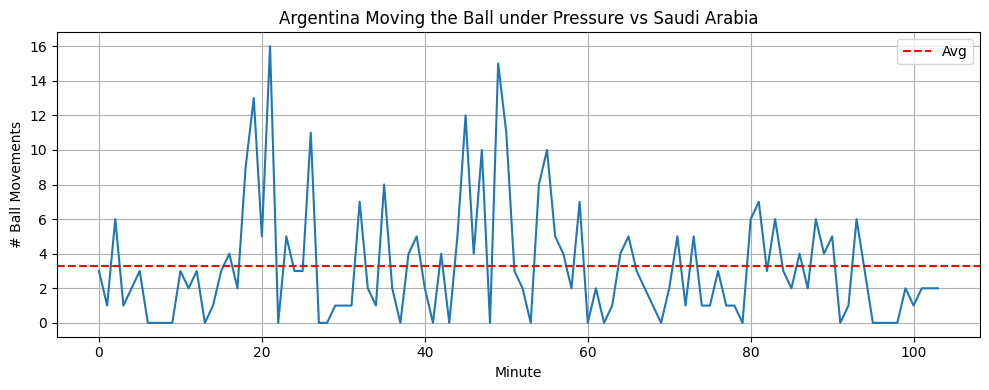

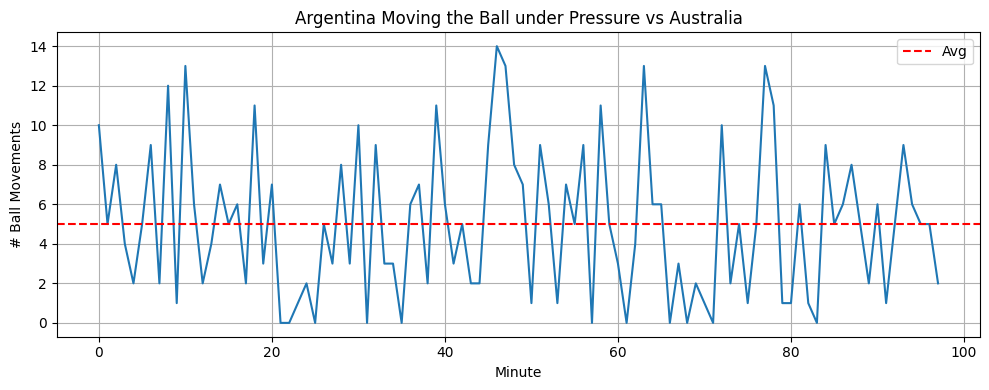

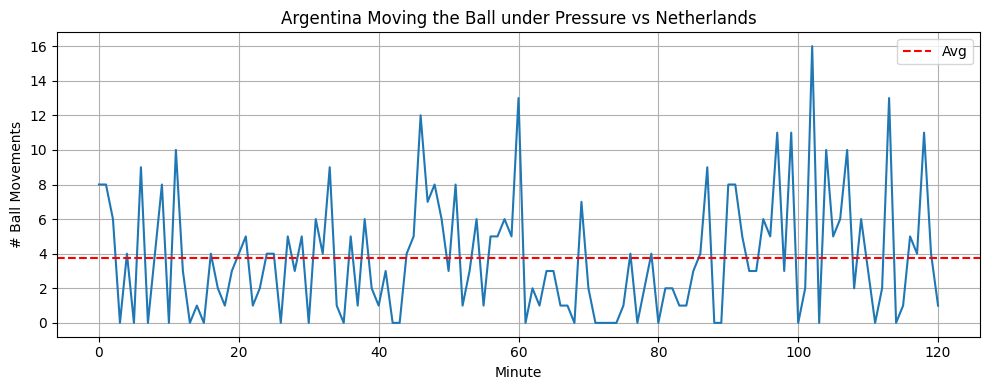

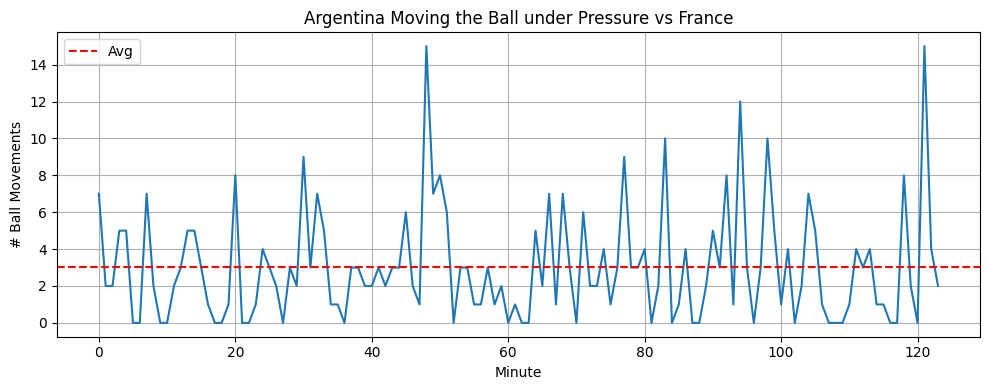

In [ ]:
for opponent, df in events_dict.items():
    # Filtering Argentina under_pressure events
    df['team_name'] = df['team'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
    up_events = df[(df['team_name'] == 'Argentina') & (df['under_pressure'] == True)]

    # Counting under_pressure events per minute
    pressure_per_min = up_events['minute'].value_counts().sort_index()

    # Creating full range to fill gaps
    full_range = pd.Series(0, index=range(0, up_events['minute'].max() + 1))
    pressure_series = full_range.add(pressure_per_min, fill_value=0)

    avg_pressure = pressure_series.mean()

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(pressure_series.index, pressure_series.values)
    plt.title(f'Argentina Moving the Ball under Pressure vs {opponent}')
    plt.xlabel('Minute')
    plt.ylabel('# Ball Movements')
    plt.axhline(y=avg_pressure, color='red', linestyle='--', label='Avg')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Argentina moved the ball under pressure against Australia a lot more than they did against other teams shown above. It suggests that while Australia did try to apply pressure to win the ball back, they weren't doing it well so Argentina could bypass it with ease.

In [ ]:
combined_all_matches = []

for opponent, df in events_dict.items():
    # Extracting Argentina under_pressure events
    df["team_name"] = df["team"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
    up_events = df[(df["team_name"] == "Argentina") & (df["under_pressure"] == True)]

    # Count under_pressure events per minute
    pressure_per_min = up_events["minute"].value_counts().sort_index()
    full_range = pd.Series(0, index=range(0, up_events["minute"].max() + 1))
    pressure_series = full_range.add(pressure_per_min, fill_value=0)

    # List of tooltip texts
    tooltip_map = defaultdict(list)
    for minute, text in tooltips.get(opponent, []):
        tooltip_map[minute].append(text)

    max_minute = max(
      pressure_series.index.max(),
      max(tooltip_map.keys(), default=0)
    )

    for minute in range(max_minute + 1):
        combined_all_matches.append({
            "opponent":  opponent,
            "minute":    minute,
            "pressure":  int(pressure_series.get(minute, 0)),
            "events":    tooltip_map.get(minute, []),

        })

with open("igm_plot.json","w",encoding="utf-8") as f:
    json.dump(combined_all_matches, f, indent=2, ensure_ascii=False)

# **Actionable Insights**

*Calculated figures are rounded up for convenience.*

## **1.  Without the Ball:**

* ***AI-1:*** Nealy all of Argentina’s pressure (98%) came down to how often they pressed (pressured opposition to lose the ball) higher up the pitch, closer to the opposition goal. For every extra tackle, block, foul, interception or 50/50, the team allowed 0.3 fewer opposition passes before disrupting play — that’s a direct impact on choking opposition buildup.

## **2. With the Ball:**

*  ***AI-2:*** A significant chunk of Argentina’s attacking threat came directly as a result of high pressing: 32% of their shots and nearly 29% of their goals came within 18 seconds of a press! These surges peaked right after halftime, when they applied the most pressure (during the 45'-60' period). It wasn’t constant — it was calculated. They picked their moments and hit fast.

* ***AI-3:*** Argentina’s most effective attacks came from deliberate build-up sequences starting deep and moving into dangerous areas. Whenever Messi was part of such sequences, the team’s chances of scoring went up by 17% on average. And out of 74 sequences, he was involved in 62!
His top move boosted their scoring odds by 99%. Without him, their best effort in the whole tournament increased their chance of scoring by just 57%. So, when Messi helped move the ball forward, Argentina were far more likely to score.

* ***AI-4:*** Messi was slightly more clinical than his teammates—he scored 3 goals when he was expected to score 2.1 goals based on the quality of chances he created. But the rest of the squad also finished well, scoring 13 goals from chances worth 10.6 goals. So, on average, Argentina scored a bit more than expected. However, they took more shots (139) and scored more non-penalty goals (16) than any other team in the tournament suggesting that volume plus solid finishing gave them the edge.

## **3.  In-Game Management:**

* ***AI-5:*** After the opening game stumble, Argentina’s coaching staff used substitutions and formation changes proactively during games —not just to react, but to stay ahead. But it didn’t always work. A switch to a 5-man defense formation after taking the lead backfired more than once. They always adapted again, and their best control came not from loading the defense, but from staying sharp and balanced in midfield with formations like 4–4–2, 4–2–3–1 and 4–3–3.